# Import Libraries

In [0]:
!pip install sporco

    100% |████████████████████████████████| 4.4MB 6.2MB/s 
    100% |████████████████████████████████| 2.6MB 10.1MB/s 


In [0]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sporco.dictlrn import cbpdndl
from sporco import util
from sporco import plot
import warnings
warnings.filterwarnings("ignore")

# Check for TPU

In [0]:
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))

except KeyError:
  print('TPU not found')

Found TPU at: grpc://10.11.60.34:8470


# Load Data

Download Data from Google Drive

In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1l6EHtc6hy2VrwLZGX0APpV09L11y2B4q' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: @NQ_Daily.txt, id: 1lNJ2Axp0utKI8d0lvWpKAaRptqjX5WNq
downloading to /root/data/@NQ_Daily.txt


In [0]:
def load_data(data, seq_len, all_data):
    sequence_length = seq_len + 1
    result = []
    
    # Turn dataset into time-series
    for index in range(len(data) - sequence_length + 1):
        result.append(data[index: index + sequence_length, :])
    
    result = np.array(result)
    # Pre-standardized Data
    original_data = result.copy()
    
    # Standardize Data
    result, scalars = standardize_windows(result)
    result = np.array(result)
    
    # Split into Training and Test Sets
    row = round(0.8 * result.shape[0])
    train_result = shuffle(result[:int(row),:,:])
    x_train = train_result[:, :-1, :]
    y_train = train_result[:, -1, 3]
    x_test = result[int(row):, :-1, :]
    y_test = result[int(row):, -1, 3]
    original_data = original_data[int(row):, -1, 3]
    dates = all_data['Date'].values[int(row)+seq_len:]
    
    return [x_train, y_train, x_test, y_test, scalars, original_data, dates]

## Standaradize Data

In [0]:
def standardize_windows(window_data):
    standardized_data = []
    scalar = []
    i = 0
    for window in window_data:
        scalar.append(StandardScaler())
        scalar[i].fit(window[:-1])
        standardized_window = scalar[i].transform(window)
        standardized_data.append(standardized_window)
        i += 1
    return standardized_data, scalar

# Helper Functions



## Create Prediction Model

In [0]:
def create_model(data):
  
  input_data = tf.keras.Input(shape=(data.shape[1],data.shape[2]))
  
  flattened = Flatten()(input_data)

  x = Dense(10, activation='relu')(flattened)
  
  x = Dense(10, activation='relu')(x)
  
  x = Dense(10, activation='relu')(x)

  x = Dense(1, activation='linear')(x)

  model = tf.keras.Model(input_data, x)

  opt = tf.train.AdamOptimizer()

  model.compile(loss='mse', optimizer=opt)

  model.summary()
  
  return model

## Plot Loss

In [0]:
def plot_loss(history):
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

## Transform Values into Directional Data

In [0]:
def directional_data(data, original_data):
    result = []
    x = 0
    y = 0
    z = 0
    for j in range(1,len(data)):
        i = j
        if abs(data[i]-original_data[i-1]) < (0.3/100*original_data[i-1]):
            result.append([0,1,0])
            x = x+1
        elif data[i] > original_data[i-1]:
            result.append([0,0,1])
            y = y+1
        else:
            result.append([1,0,0])
            z = z+1
    print("No change: " + str(x))
    print("Up: " + str(y))
    print("Down: " + str(z))
    result = np.array(result)
    return result

## Plot Results

In [0]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

## Plot Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ["Down", "No Change", "Up"]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    mpl.rcParams['axes.grid'] = False
    fig, ax = plt.subplots(1,1, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig.show
    return ax

# Experiments


## Define Constants and Load Data

In [0]:
epochs  = 100
seq_len = 7

with open(fname, 'r') as f:
  all_data = pd.read_csv(f, sep=',')
df = all_data.drop(["Date","Time", "OpenBar", "FLS"], axis=1)

## First Half

### Load Data

In [0]:
x_train, y_train, x_test, y_test, scalars, original_data, dates = load_data(df.values[:int(len(df)/2)], seq_len, all_data[:int(len(df)/2)])

x_train = np.transpose(x_train, (1,2,0))
x_test = np.transpose(x_test, (1,2,0))

### Convolutional Sparse Coding

In [0]:
filter_length = 5
num_filters = 500

D0 = np.random.randn(filter_length, x_train.shape[1], num_filters)
lmbda = 0.05
opt = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True, 'MaxMainIter': 10,
                        'CBPDN': {'rho': 50.0*lmbda + 0.5},
                        'CCMOD': {'rho': 10.0}},
                        dmethod='cns')
csc = cbpdndl.ConvBPDNDictLearn(D0, x_train, lmbda, opt, dmethod='cns', dimK=None, dimN=1)
D1 = csc.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  8.38e+03  8.44e+02  1.51e+05  4.02e-15  3.20e-01  2.64e+00  3.00e+00  1.02e-01  7.19e-02  1.00e+01
   1  7.72e+03  4.06e+01  1.54e+05  4.34e-15  2.22e-01  1.07e+00  3.00e+00  7.74e-02  1.70e-02  1.00e+01
   2  6.97e+03  1.91e+02  1.36e+05  3.76e-15  1.69e-01  5.58e-01  3.00e+00  6.51e-02  1.19e-01  1.00e+01
   3  6.85e+03  1.09e+02  1.35e+05  4.11e-15  1.36e-01  4.54e-01  3.00e+00  4.84e-02  3.79e-02  1.00e+01
   4  6.18e+03  7.91e+01  1.22e+05  4.01e-15  1.09e-01  4.18e-01  3.00e+00  4.08e-02  8.95e-02  1.00e+01
   5  5.88e+03  1.13e+02  1.15e+05  4.30e-15  8.28e-02  3.52e-01  3.00e+00  3.16e-02  1.11e-01  1.00e+01
   6  5.72e+03  8.91e+01  1.13e+05  3.88e-15  6.78e-02  3.22e-01  3.00e+00  2.60e-02  5.80e-02  1.00e+01
   7  5.42e+03  7.71e+01  1.07e+05  3.92e-15  5.58e-02 

### Reconstruction

#### Training Data

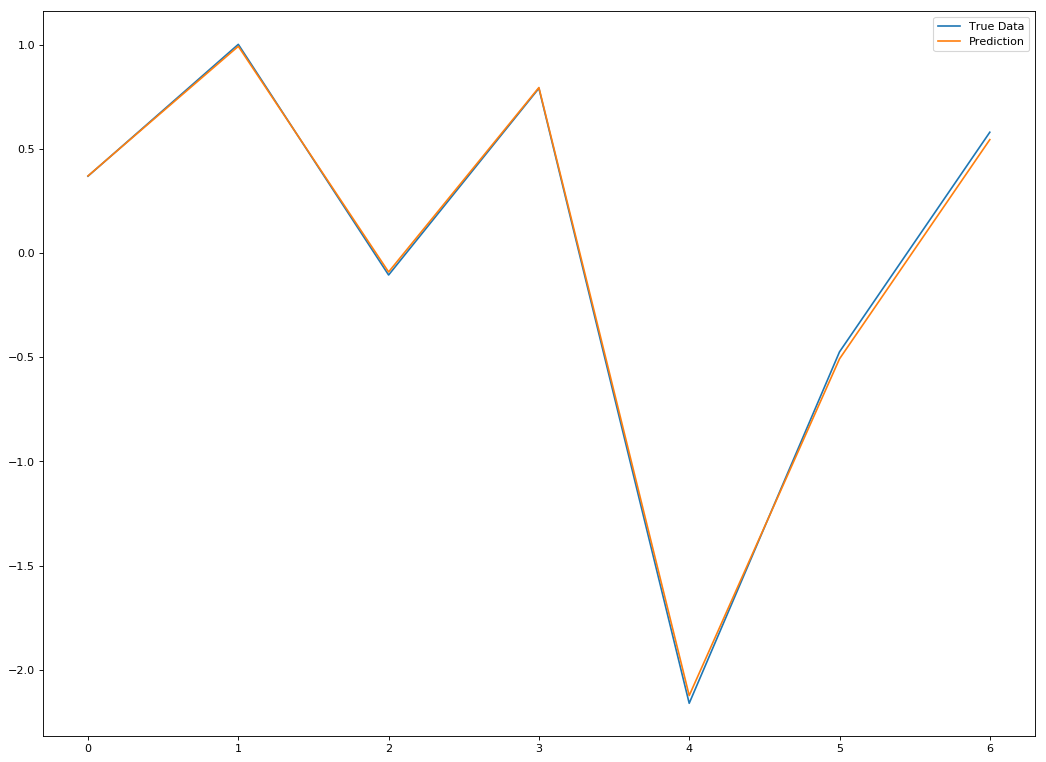

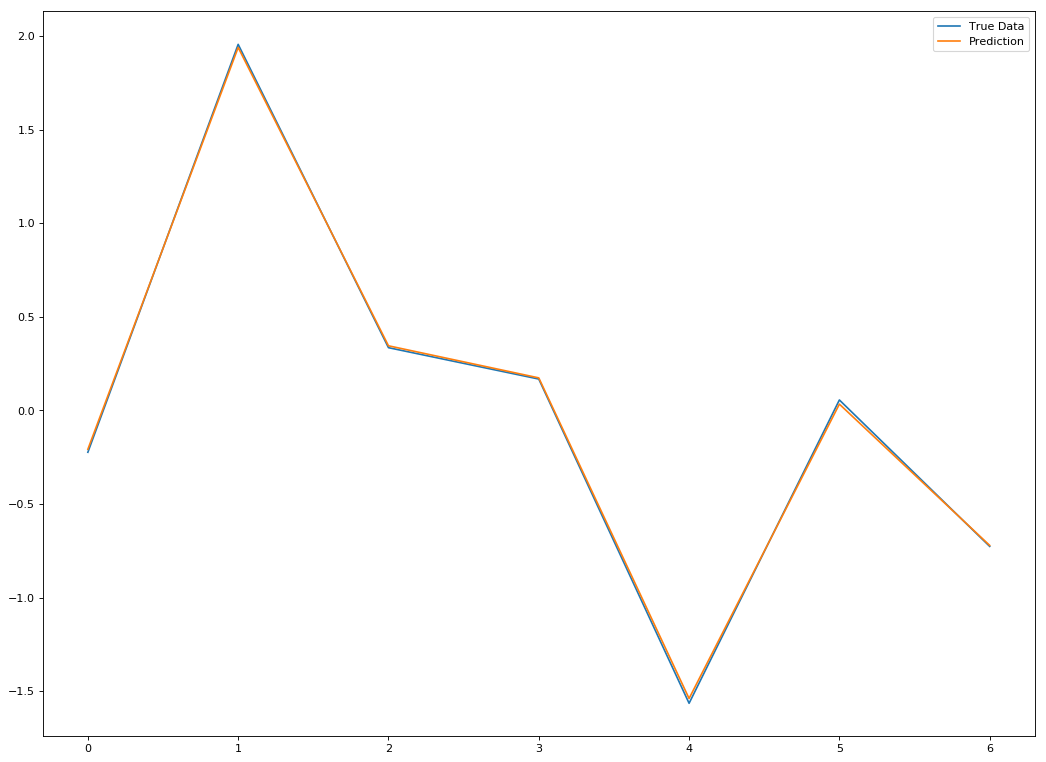

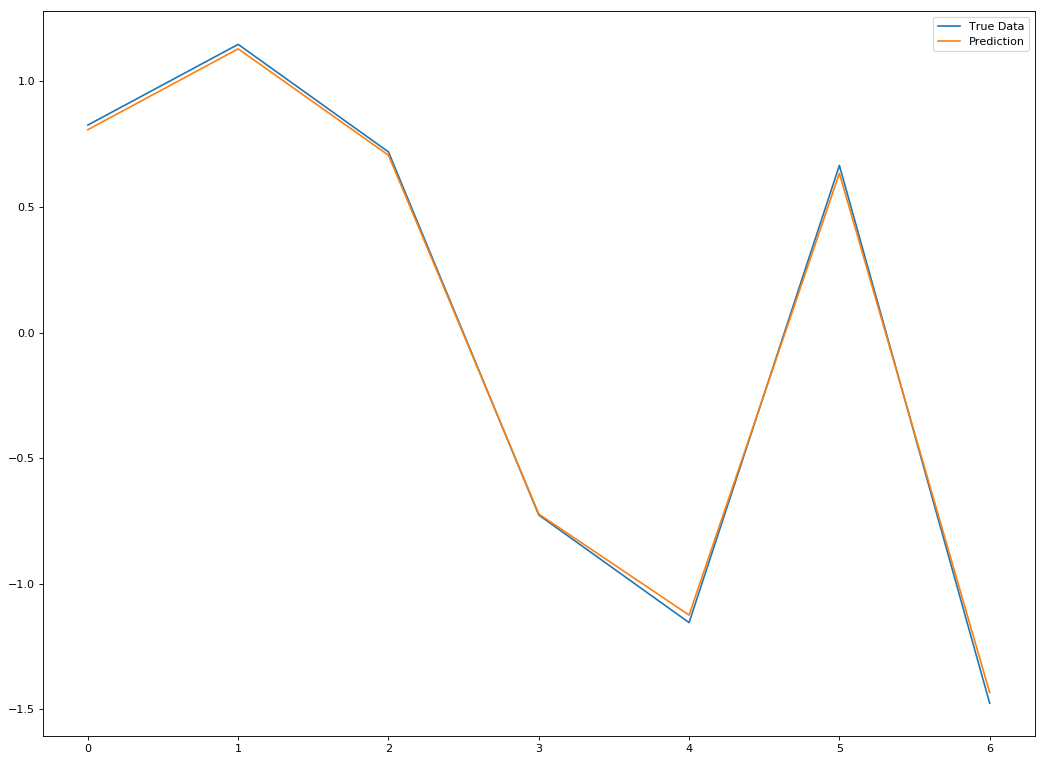

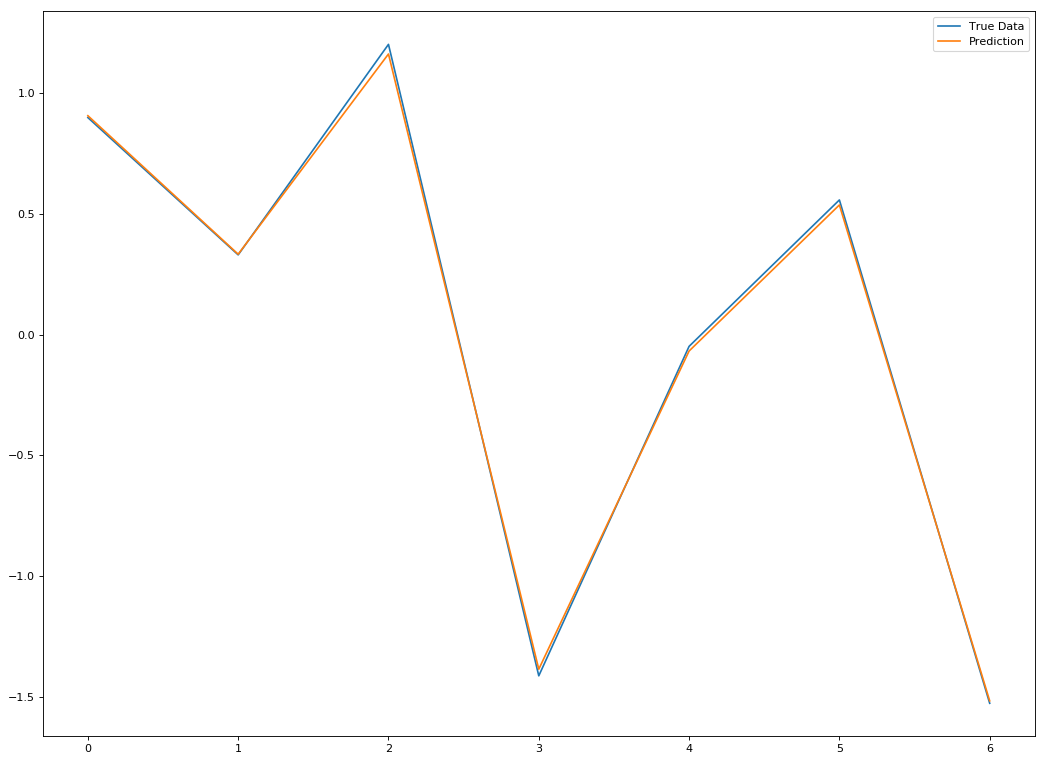

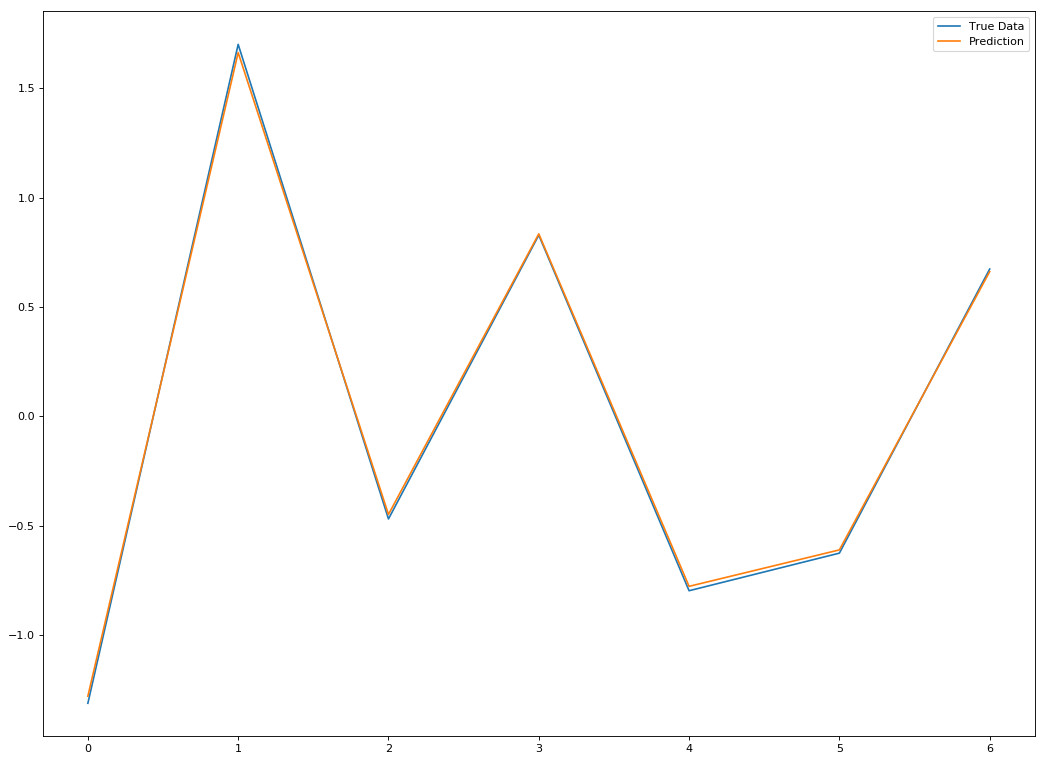

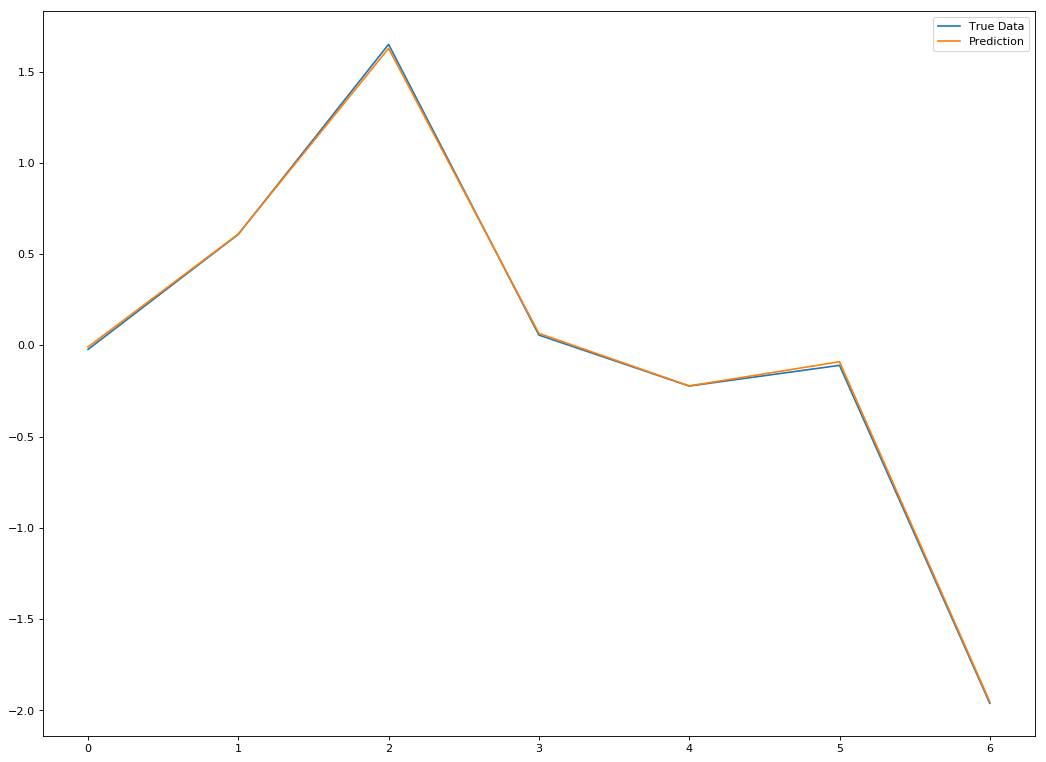

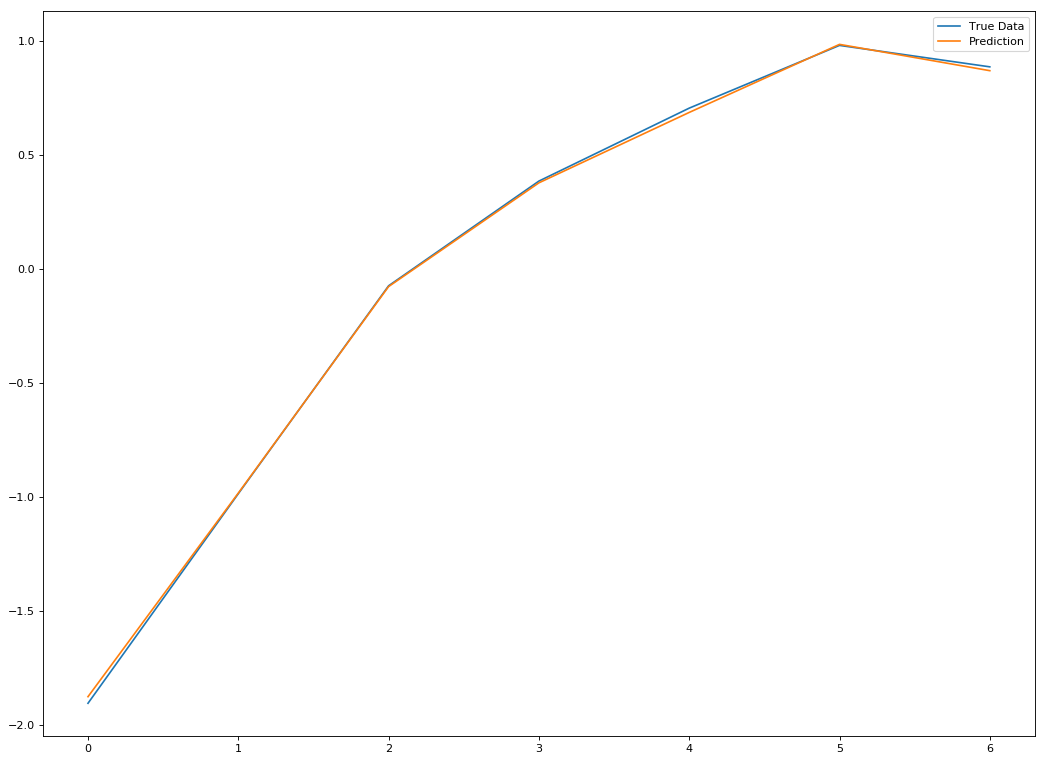

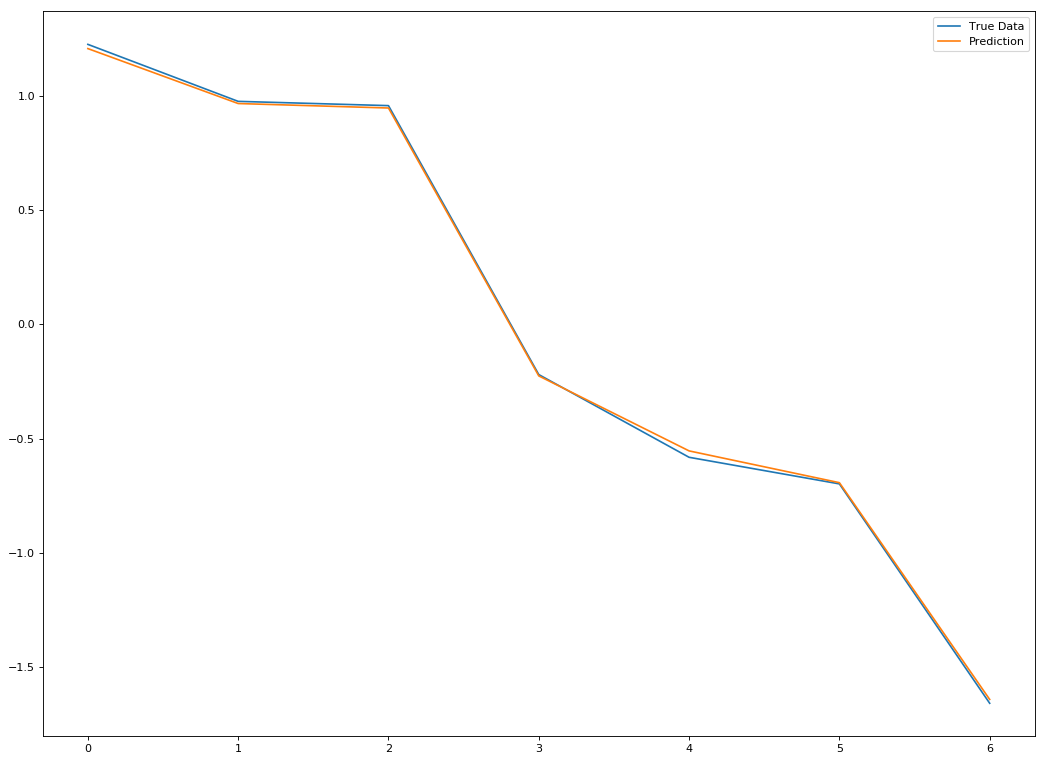

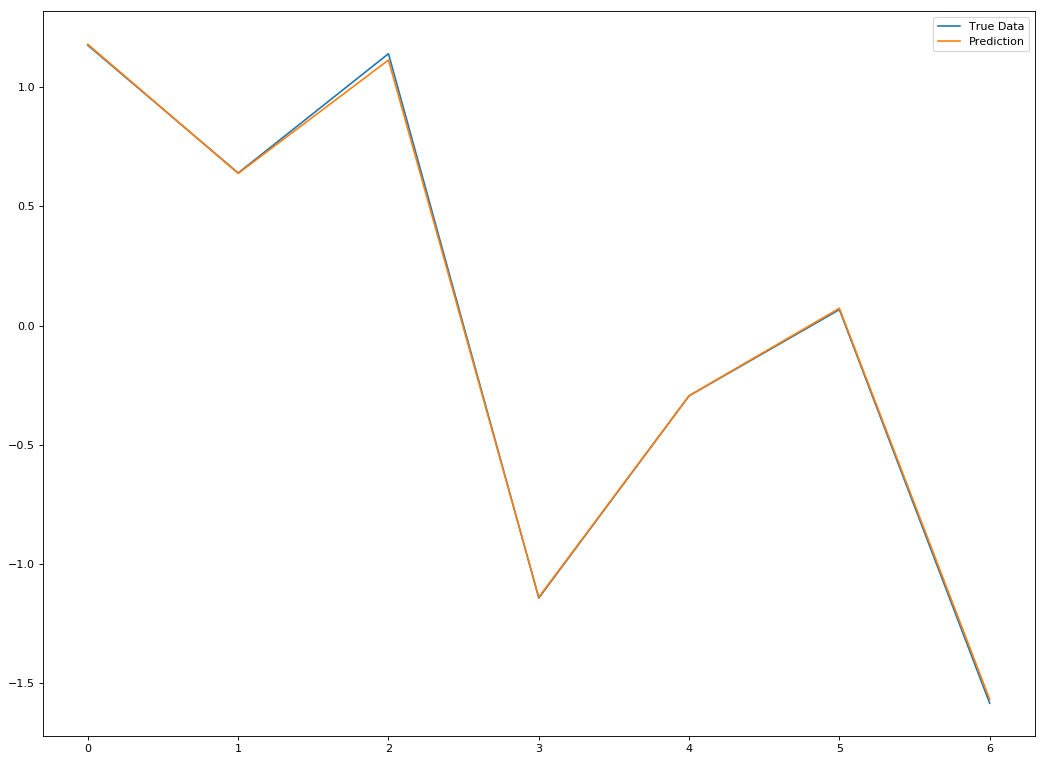

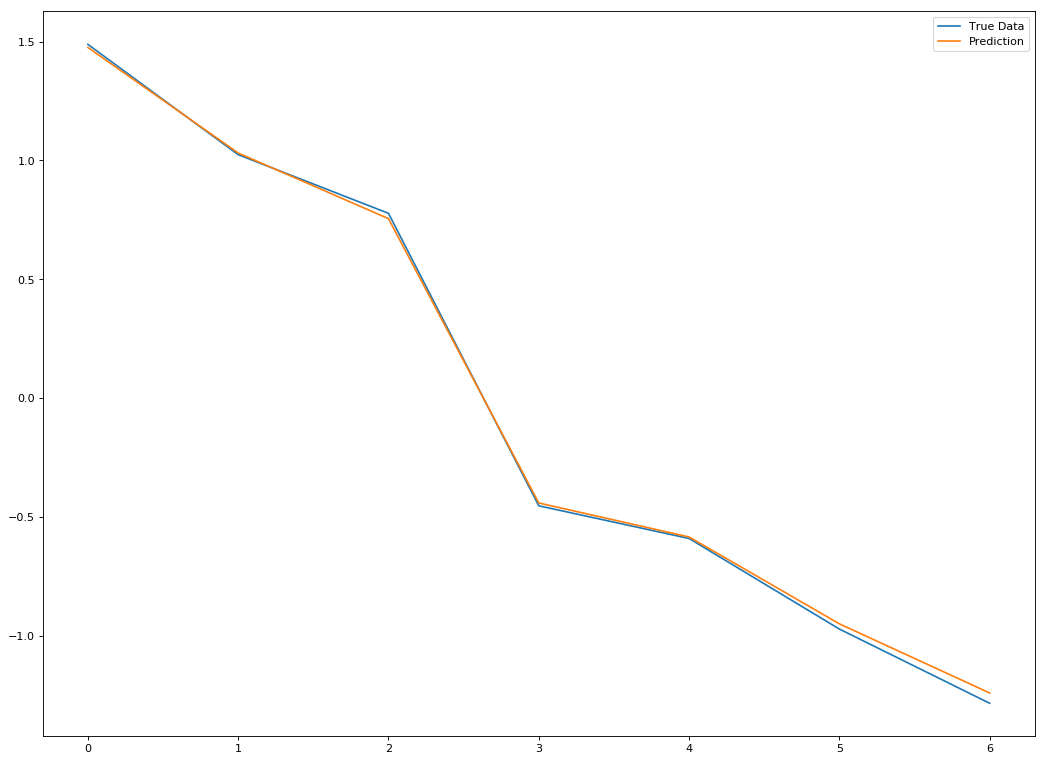

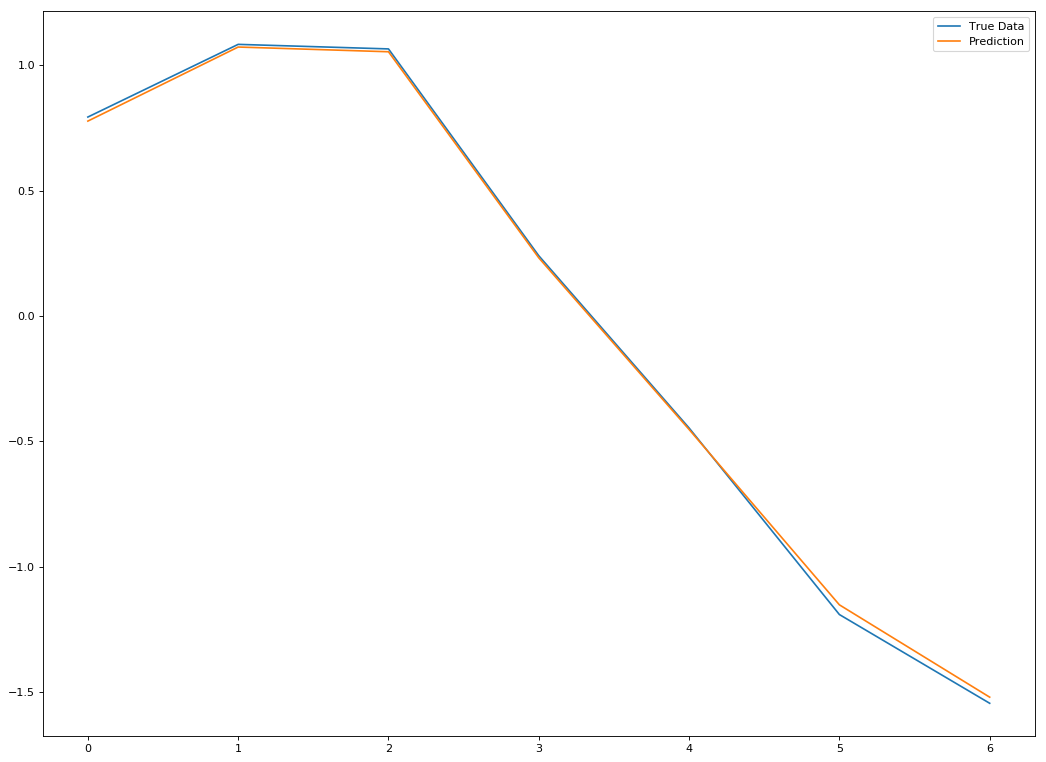

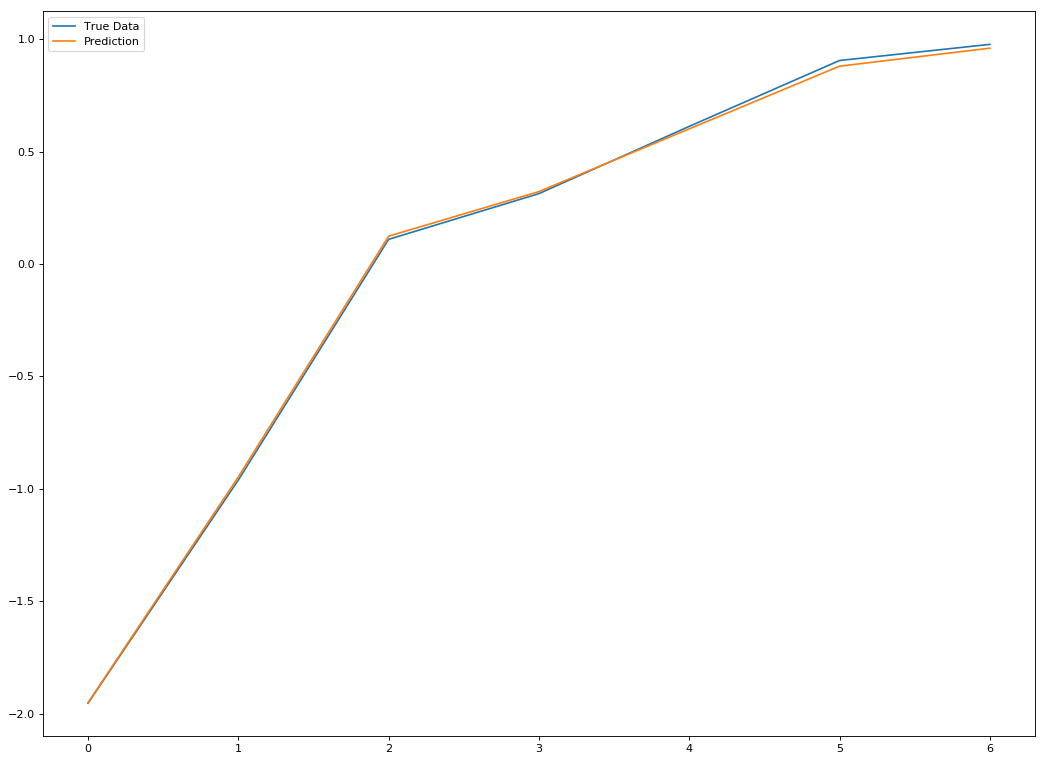

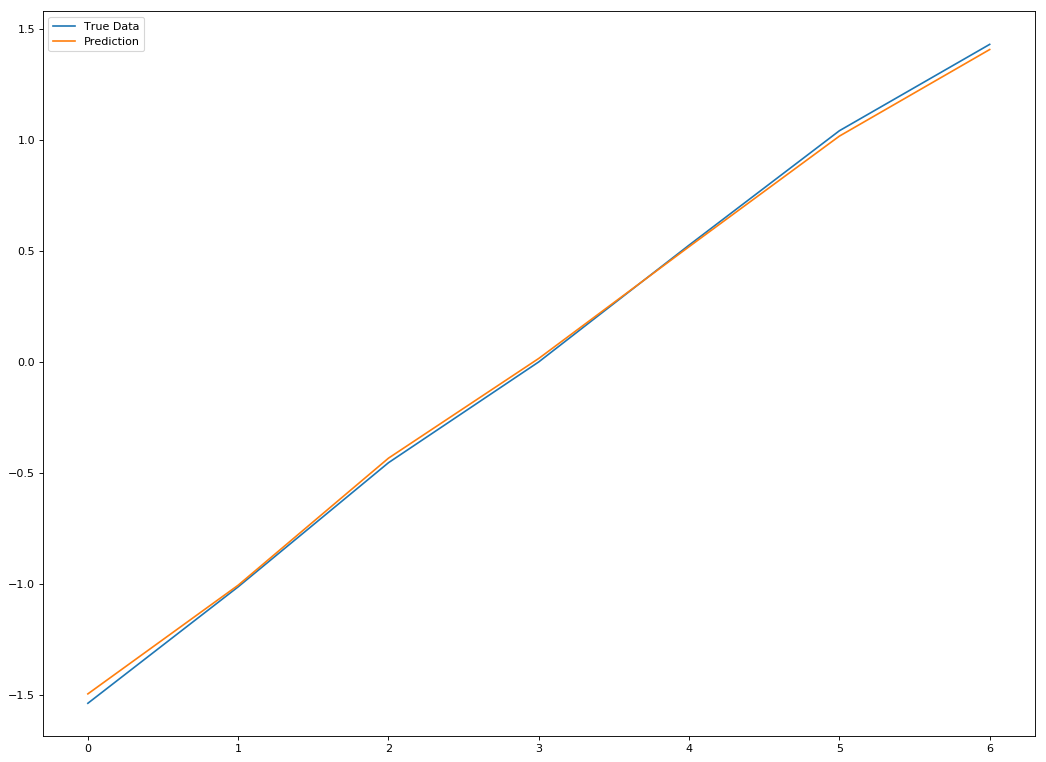

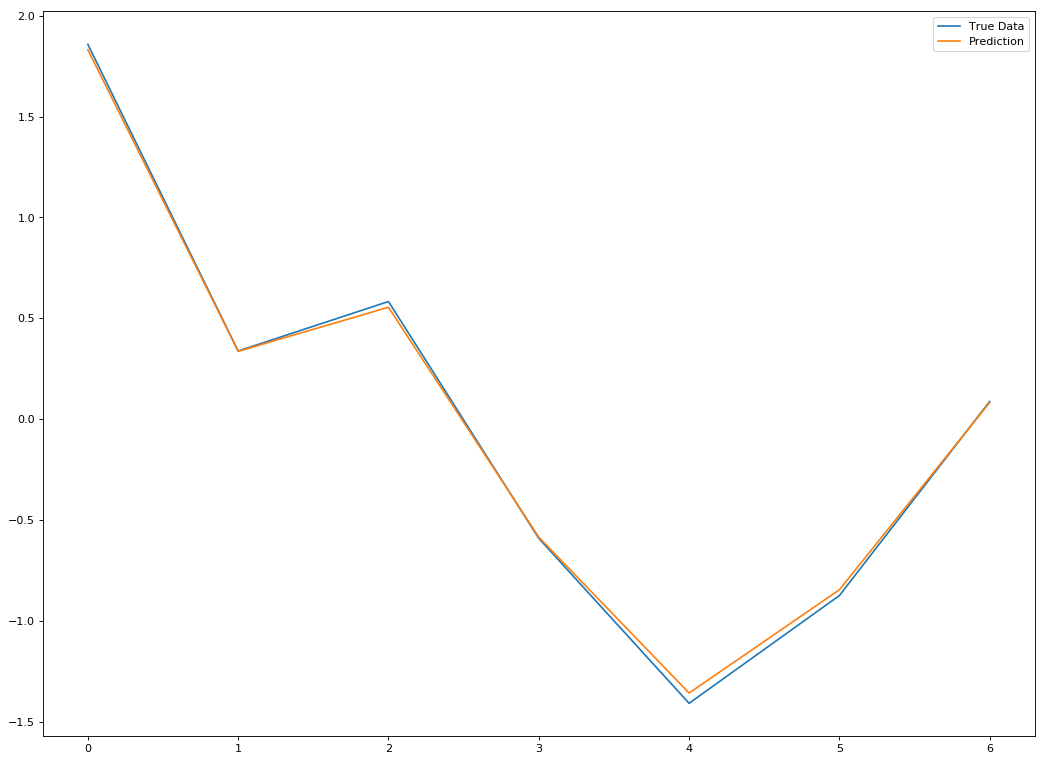

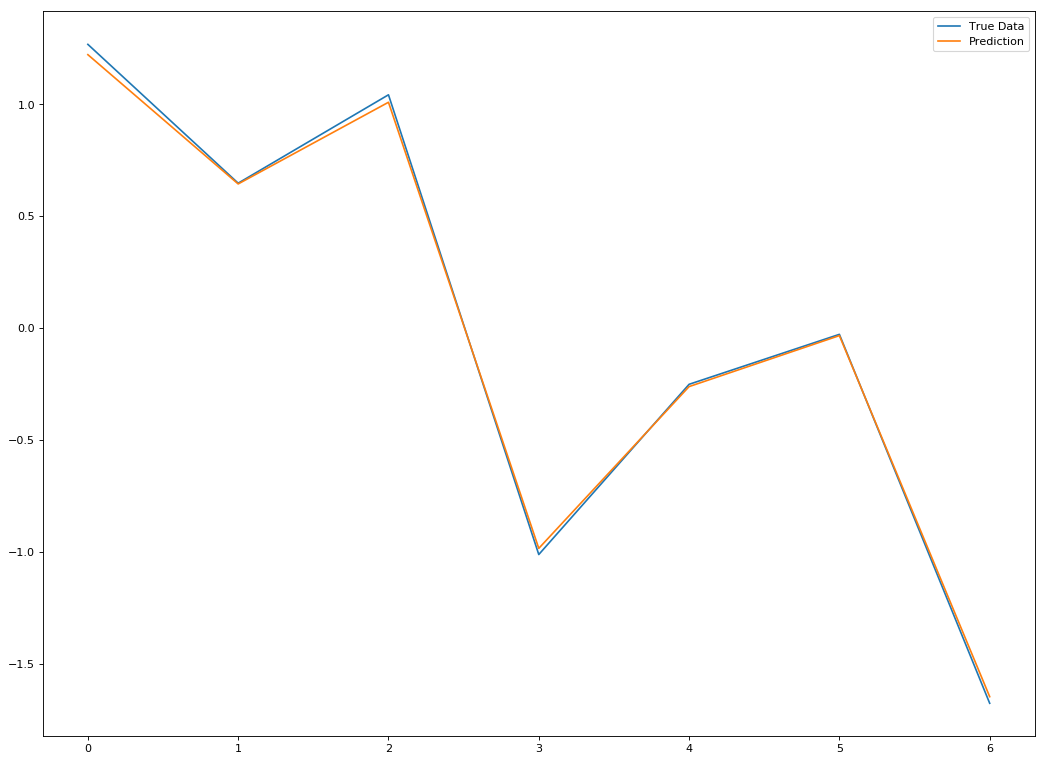

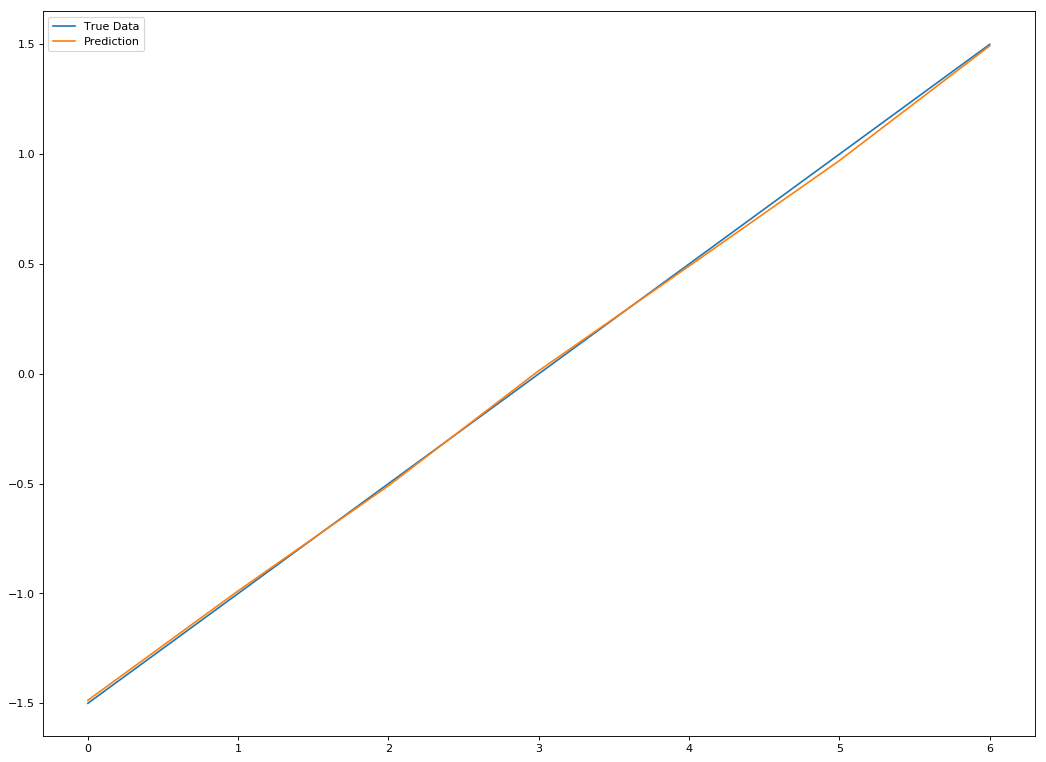

In [0]:
reconstructed_train = csc.reconstruct().squeeze()

for i in range(x_train.shape[1]):
  plot_results(reconstructed_train[:,i,0], x_train[:,i,0])

In [0]:
x_train = csc.getcoef()

#### Testing Data

In [0]:
D1 = np.array(D1)
D1 = D1.reshape(D1.shape[0], D1.shape[1], -1)

In [0]:
csc = cbpdndl.ConvBPDNDictLearn(D1, x_test, lmbda, opt, dmethod='cns', dimK=None, dimN=1)
D1 = csc.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  2.02e+03  1.90e+02  3.67e+04  4.12e-15  3.19e-01  2.57e+00  3.00e+00  1.02e-01  7.29e-02  1.00e+01
   1  1.87e+03  9.97e+00  3.72e+04  4.15e-15  2.24e-01  1.04e+00  3.00e+00  7.73e-02  1.23e-02  1.00e+01
   2  1.69e+03  4.34e+01  3.29e+04  3.86e-15  1.72e-01  5.47e-01  3.00e+00  6.50e-02  1.11e-01  1.00e+01
   3  1.66e+03  2.65e+01  3.27e+04  4.28e-15  1.37e-01  4.50e-01  3.00e+00  4.84e-02  4.26e-02  1.00e+01
   4  1.50e+03  1.85e+01  2.96e+04  3.89e-15  1.09e-01  4.20e-01  3.00e+00  4.08e-02  7.56e-02  1.00e+01
   5  1.42e+03  2.64e+01  2.79e+04  4.38e-15  8.35e-02  3.47e-01  3.00e+00  3.16e-02  1.02e-01  1.00e+01
   6  1.39e+03  2.17e+01  2.73e+04  3.76e-15  6.80e-02  3.18e-01  3.00e+00  2.59e-02  4.48e-02  1.00e+01
   7  1.32e+03  1.83e+01  2.60e+04  3.95e-15  5.58e-02 

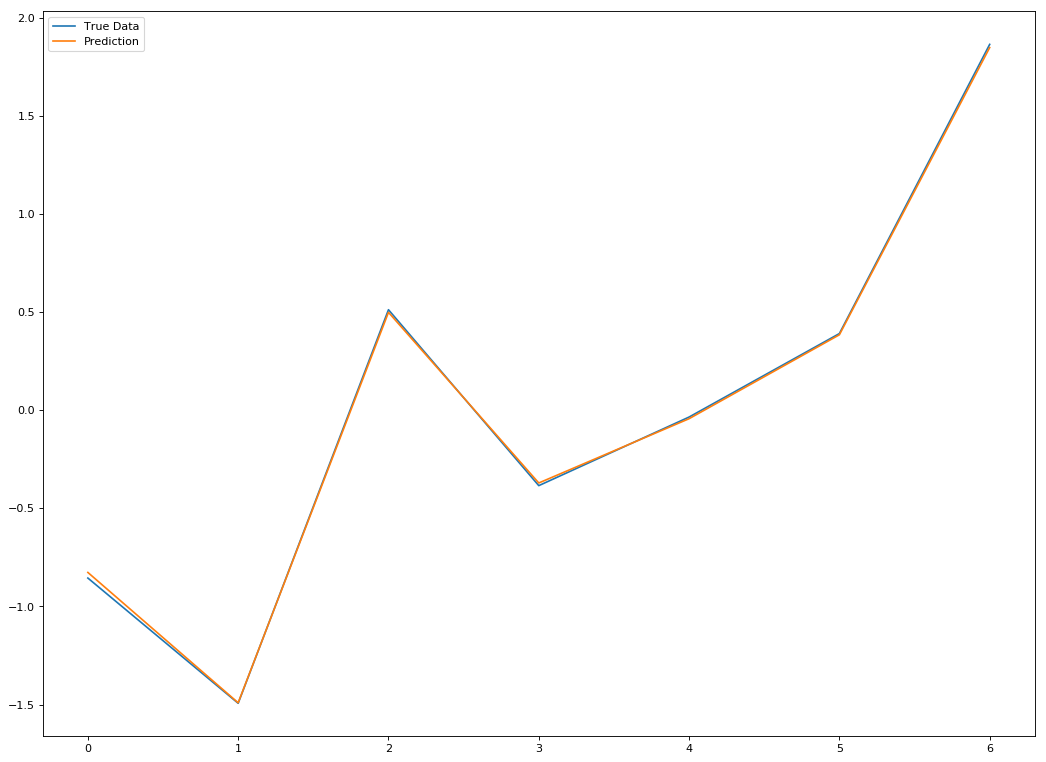

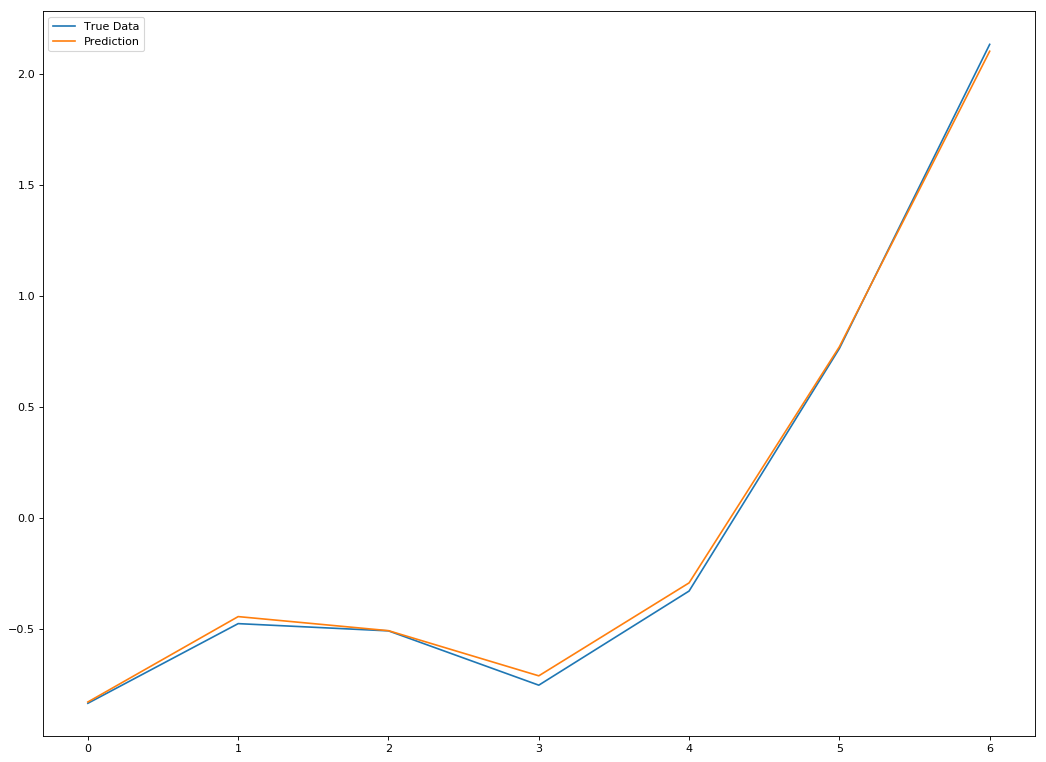

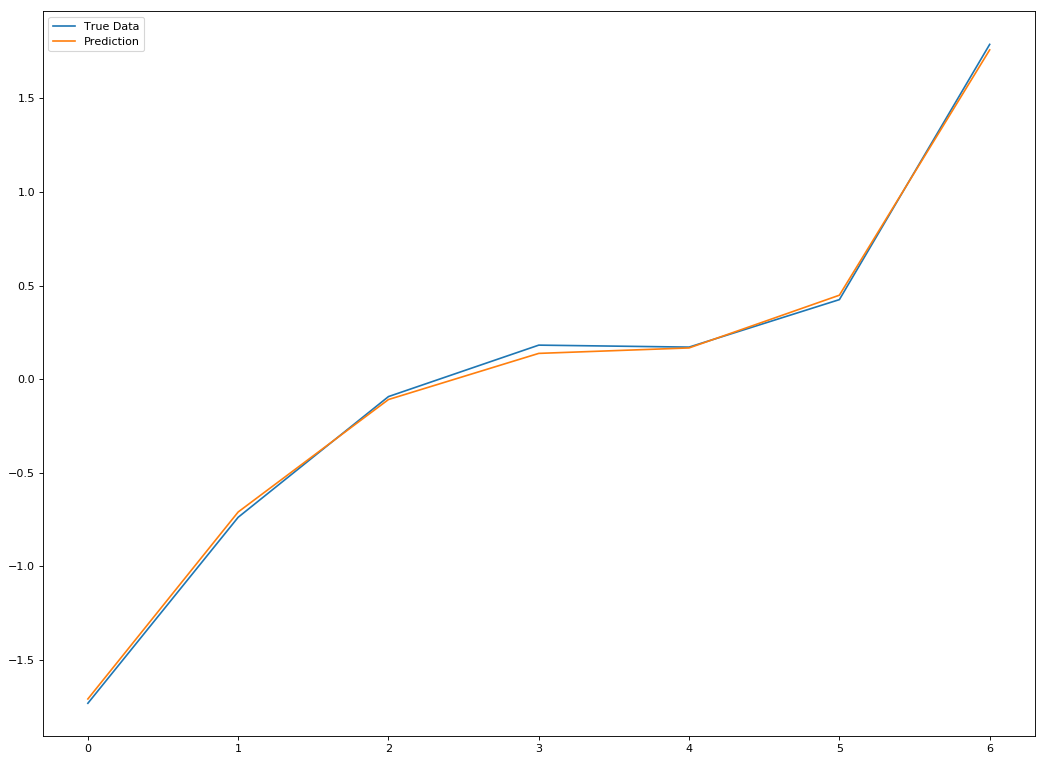

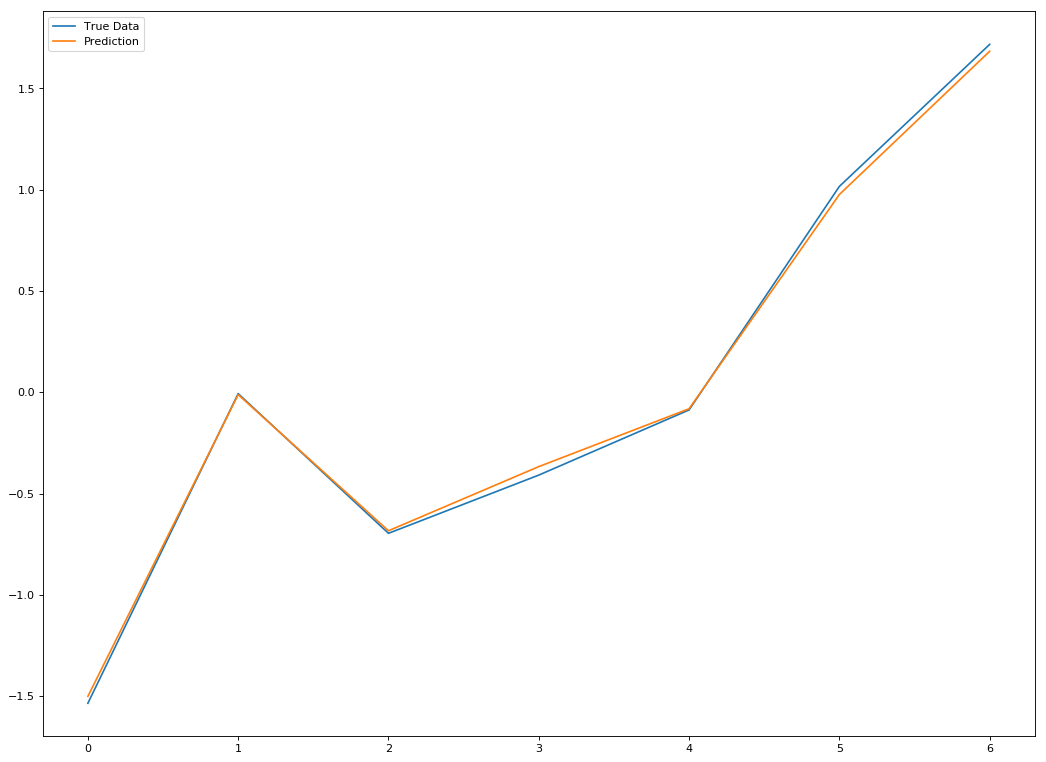

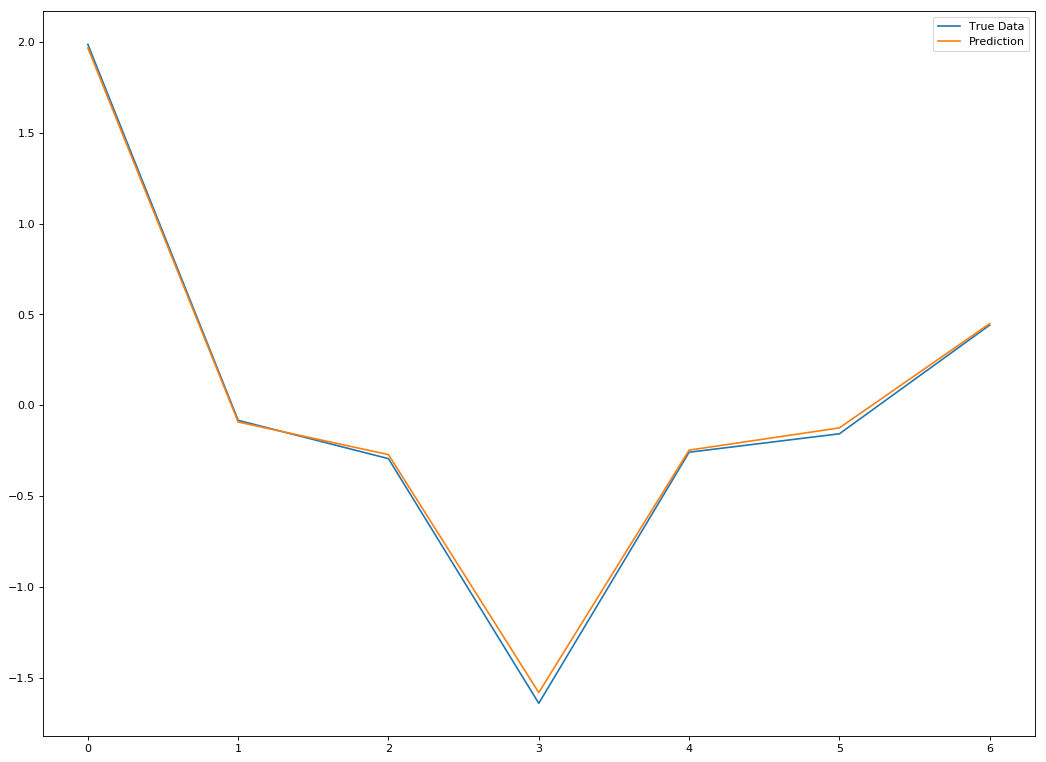

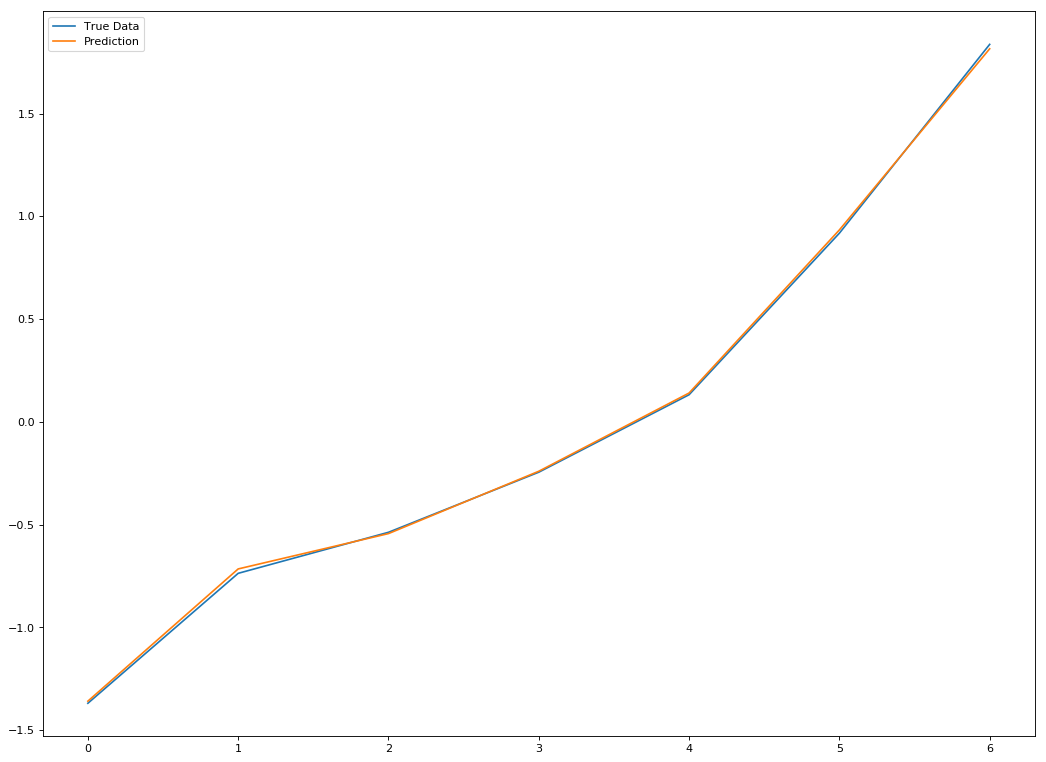

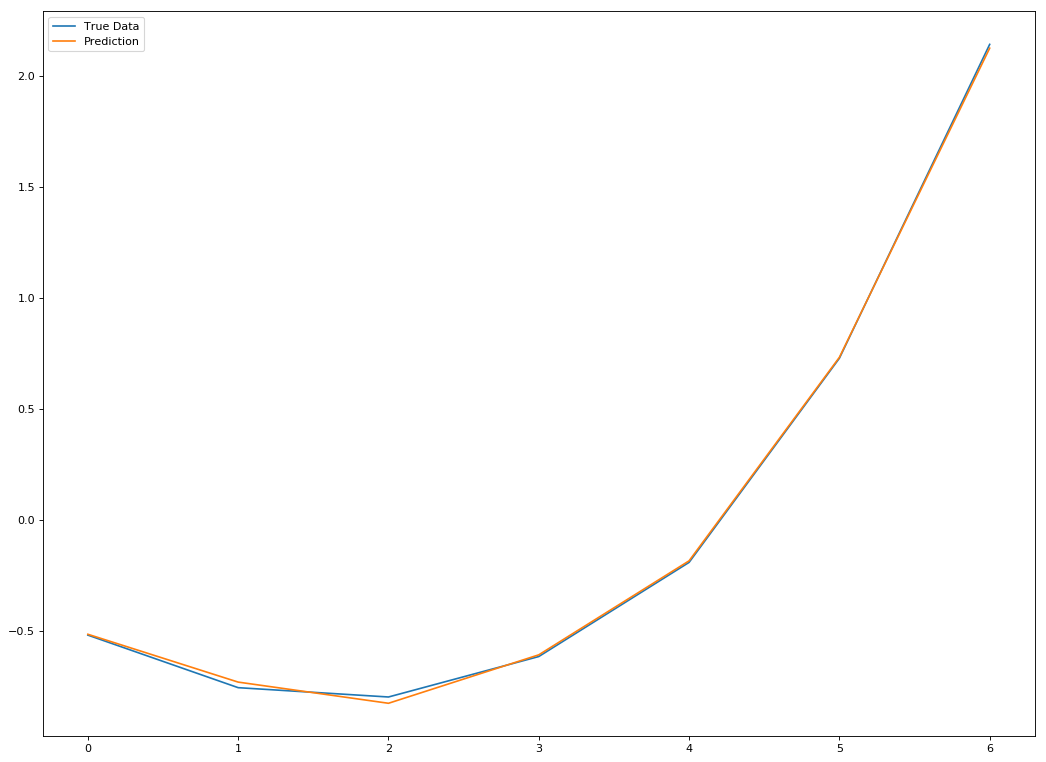

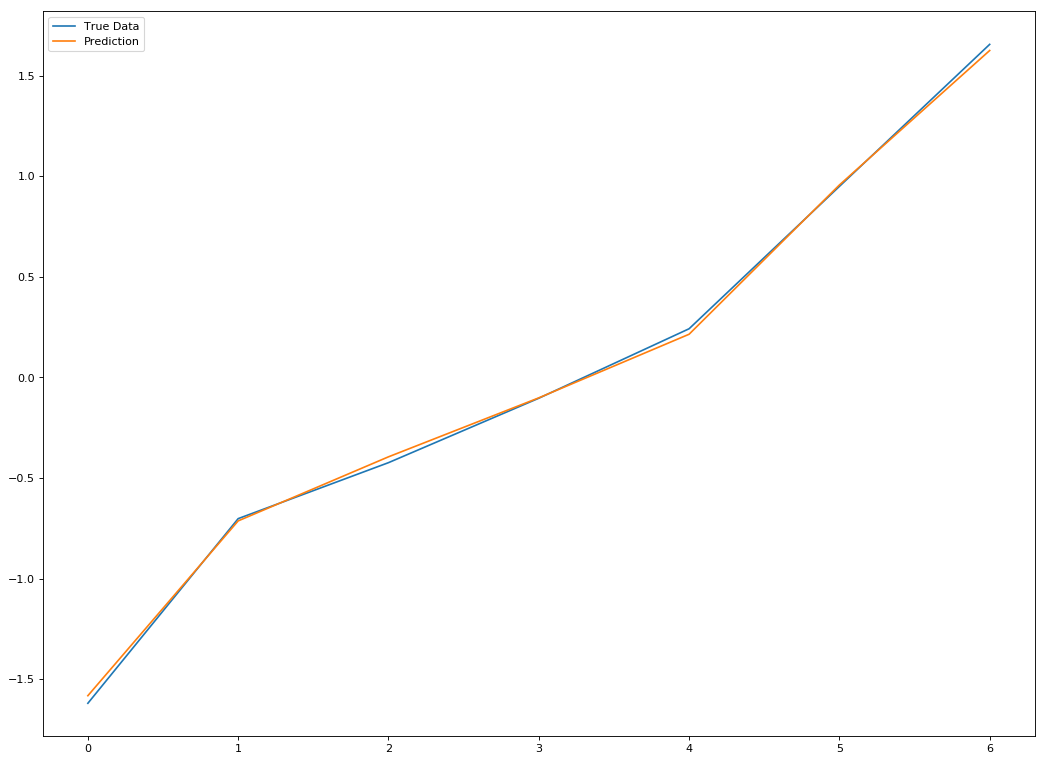

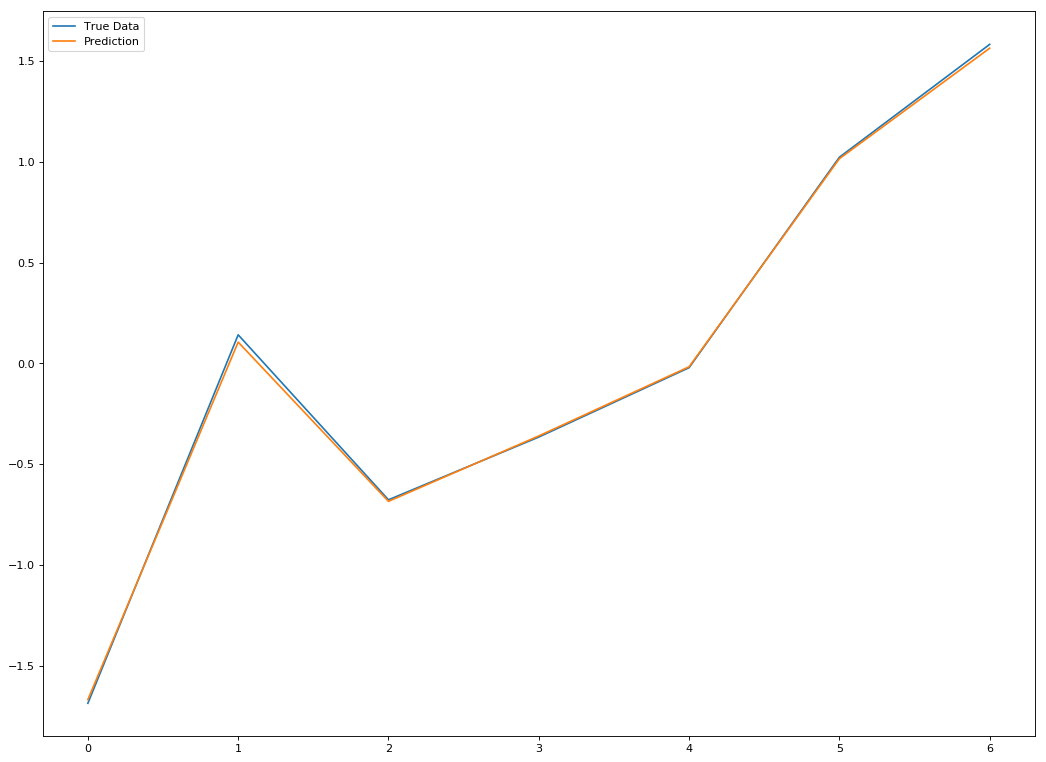

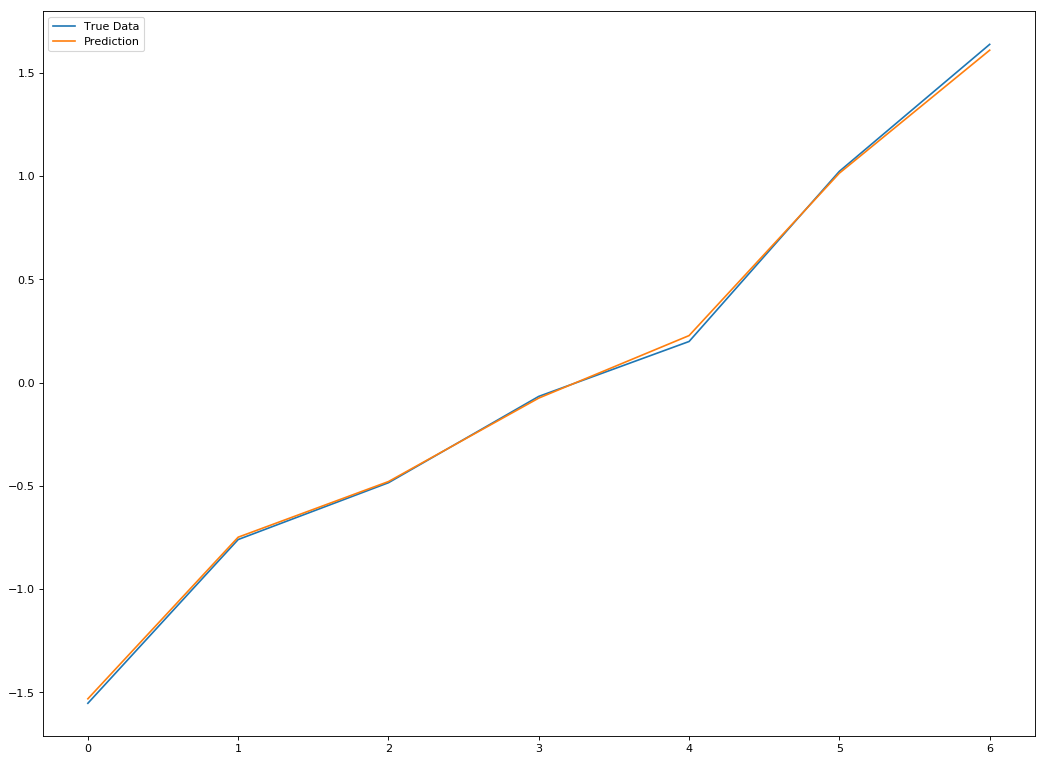

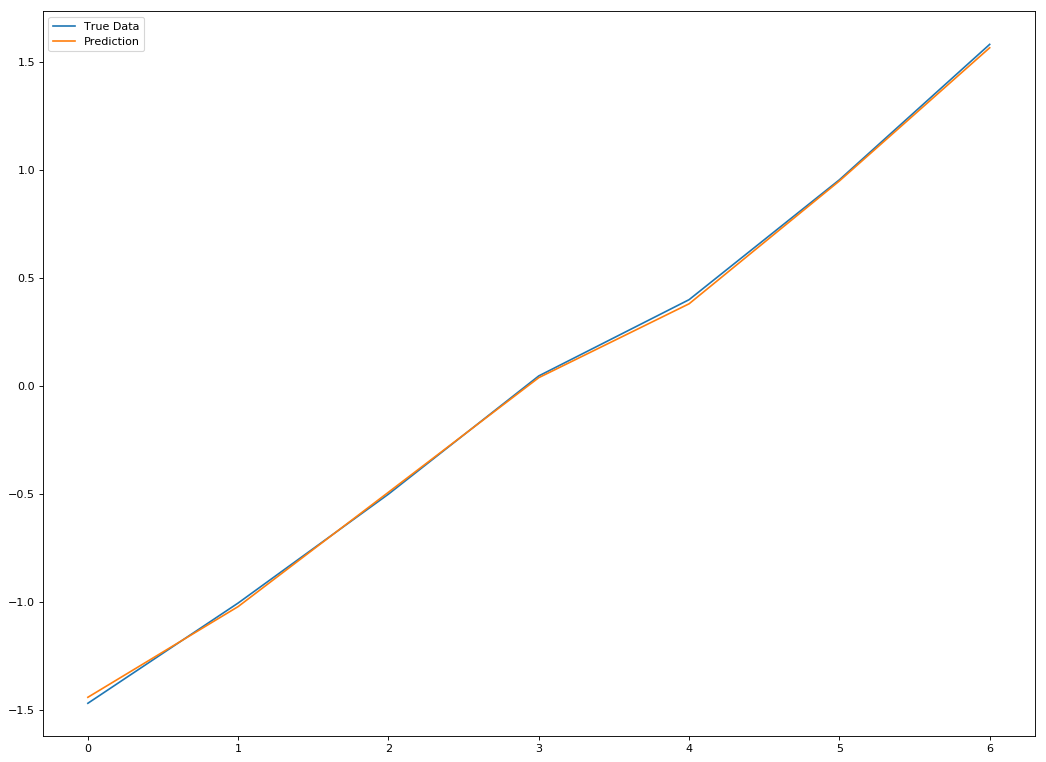

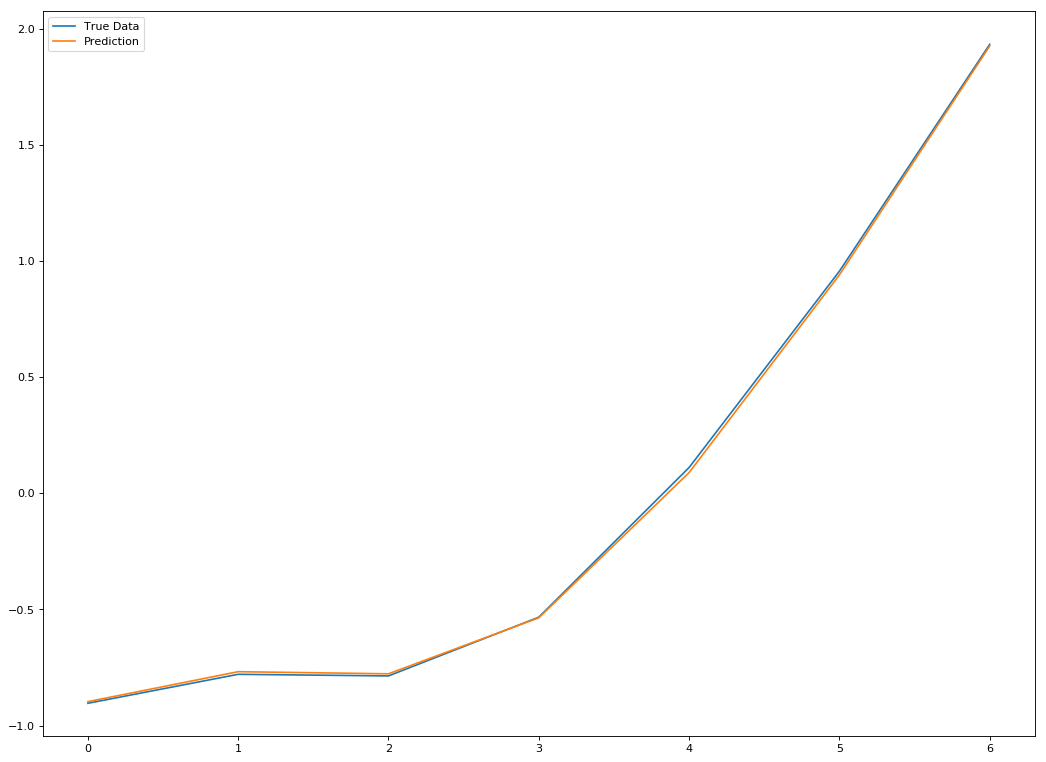

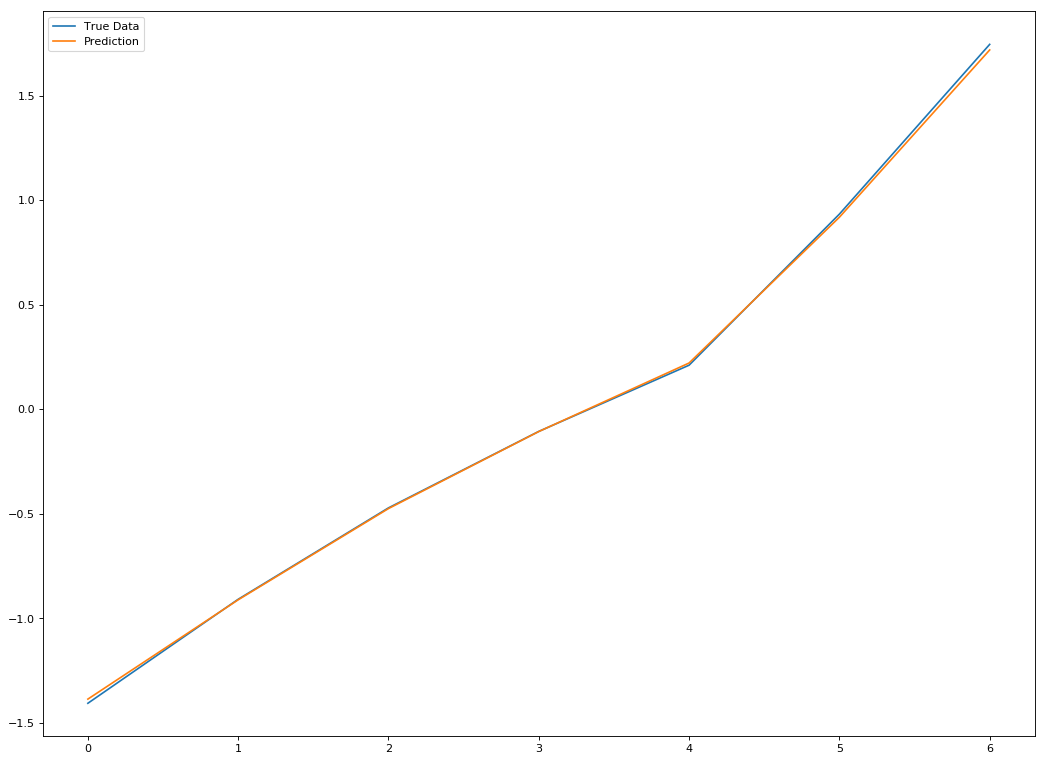

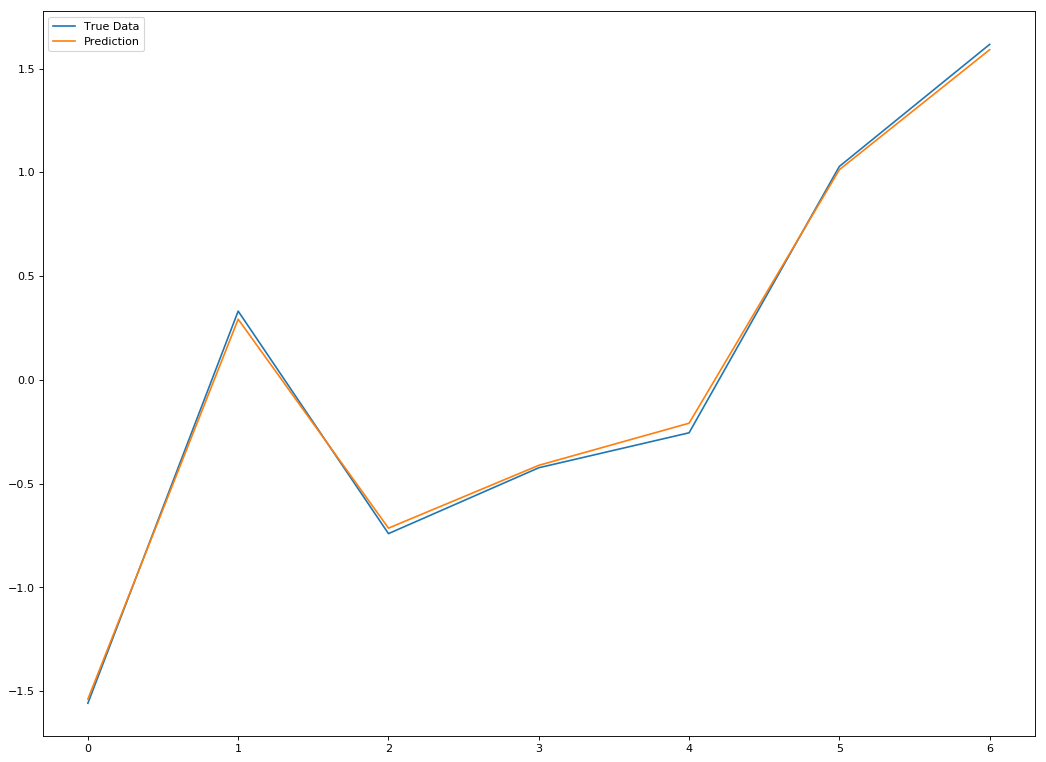

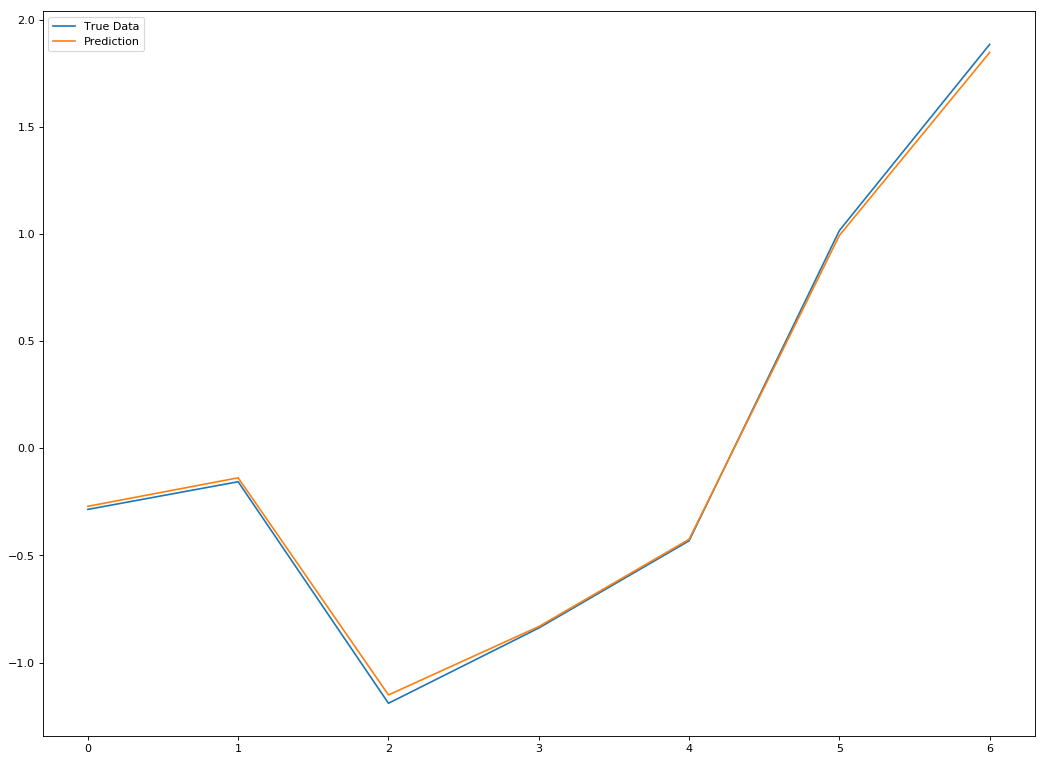

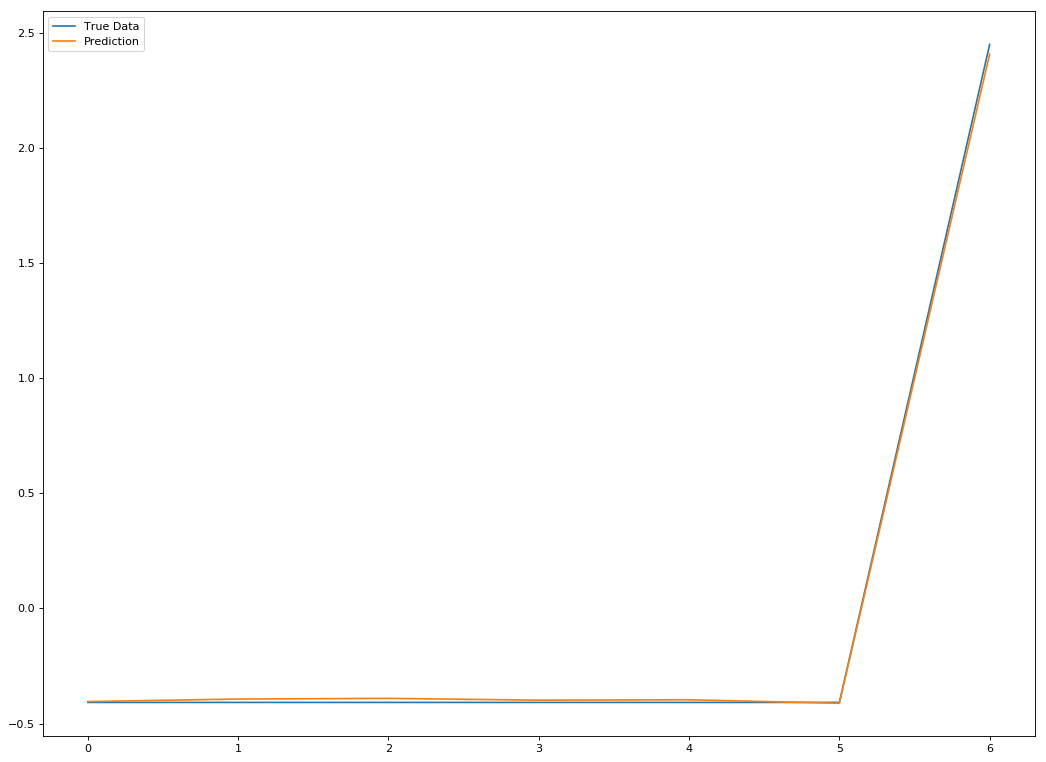

In [0]:
reconstructed_test = csc.reconstruct().squeeze()
for i in range(x_test.shape[1]):
  plot_results(reconstructed_test[:,i,0], x_test[:,i,0])

In [0]:
x_test = csc.getcoef()

### Show Dictionary

In [0]:
D1 = np.array(D1)
D1 = D1.reshape(D1.shape[0], D1.shape[1], -1)

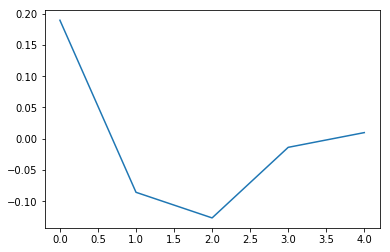

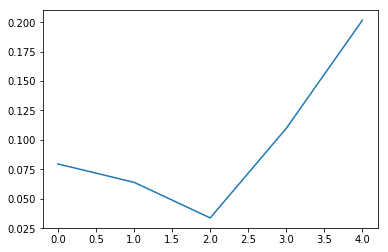

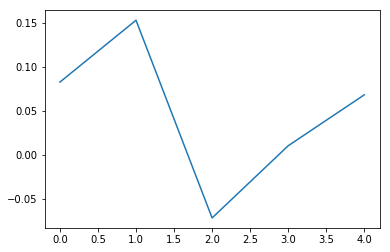

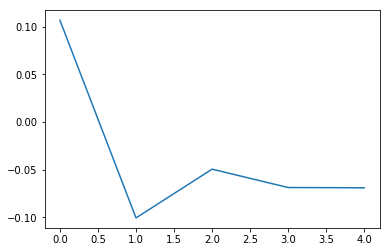

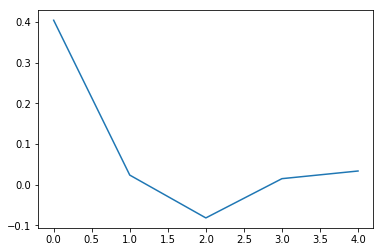

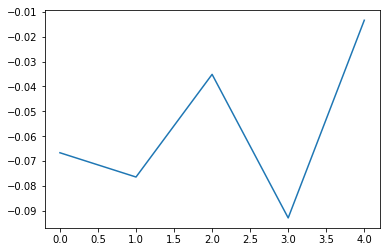

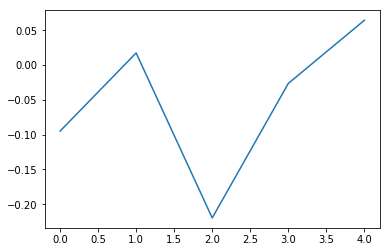

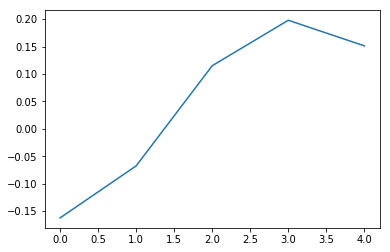

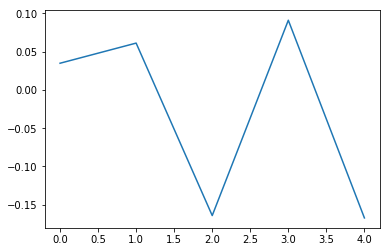

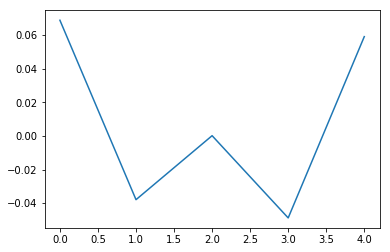

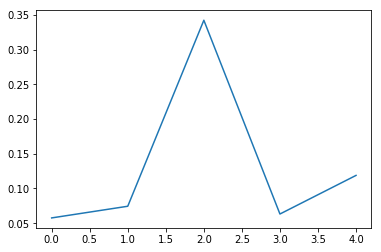

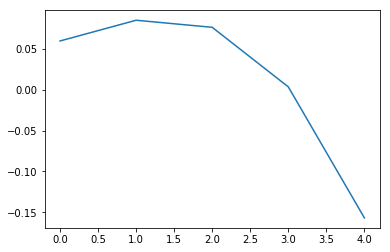

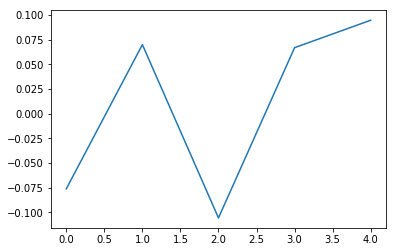

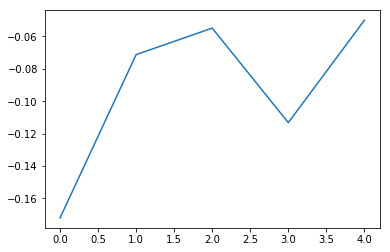

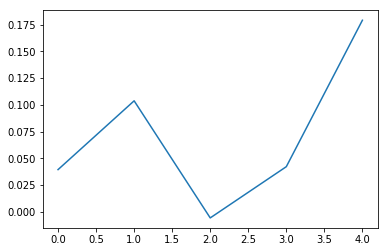

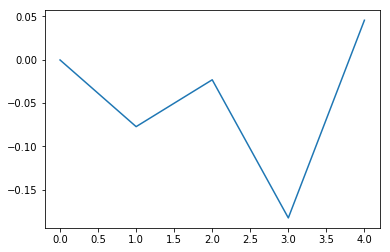

In [0]:
for i in range(D1.shape[1]):
  plt.plot(D1[:,i,0])
  plt.show()

### Create Prediction Model

In [0]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[2],-1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2],-1)

x_train = np.transpose(x_train, (1,0,2))
x_test = np.transpose(x_test, (1,0,2))

In [0]:
model = create_model(x_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 7, 500)            0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 3500)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 10)                35010     
_________________________________________________________________
dense_60 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_61 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 11        
Total params: 35,241
Trainable params: 35,241
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [0]:
callbacks_list = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]

history = model.fit(x_train,
                    y_train,
                    batch_size=256,
                    epochs=5000,
                    shuffle=True,
                    callbacks=callbacks_list,
                    validation_split=0.1,
                    verbose=1)

model.save('csc_first_half.h5')

Train on 1661 samples, validate on 185 samples
Epoch 1/5000
1661/1661 [==============================] - 2s 1ms/sample - loss: 3.0451 - val_loss: 2.5700
Epoch 2/5000
1661/1661 [==============================] - 0s 69us/sample - loss: 2.7815 - val_loss: 2.2980
Epoch 3/5000
1661/1661 [==============================] - 0s 63us/sample - loss: 2.5255 - val_loss: 2.0653
Epoch 4/5000
1661/1661 [==============================] - 0s 61us/sample - loss: 2.3054 - val_loss: 1.8956
Epoch 5/5000
1661/1661 [==============================] - 0s 64us/sample - loss: 2.1365 - val_loss: 1.7710
Epoch 6/5000
1661/1661 [==============================] - 0s 62us/sample - loss: 1.9945 - val_loss: 1.6769
Epoch 7/5000
1661/1661 [==============================] - 0s 60us/sample - loss: 1.8820 - val_loss: 1.6006
Epoch 8/5000
1661/1661 [==============================] - 0s 62us/sample - loss: 1.7889 - val_loss: 1.5517
Epoch 9/5000
1661/1661 [==============================] - 0s 65us/sample - loss: 1.7098 - val_loss

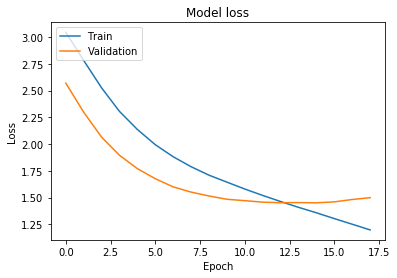

In [0]:
plot_loss(history)

### Predict for Test Set

In [0]:
predicted = model.predict(x_test)

### Rescale Data

In [0]:
new_predicted = []

for i in range(len(predicted)):
  temp = np.zeros((x_train.shape[2],))
  # 3 for closing price
  temp[3] = predicted[i]
  new_predicted.append(scalars[len(x_train)+i].inverse_transform(temp)[3])
  
predicted = np.array(new_predicted)

### Plot Predictions

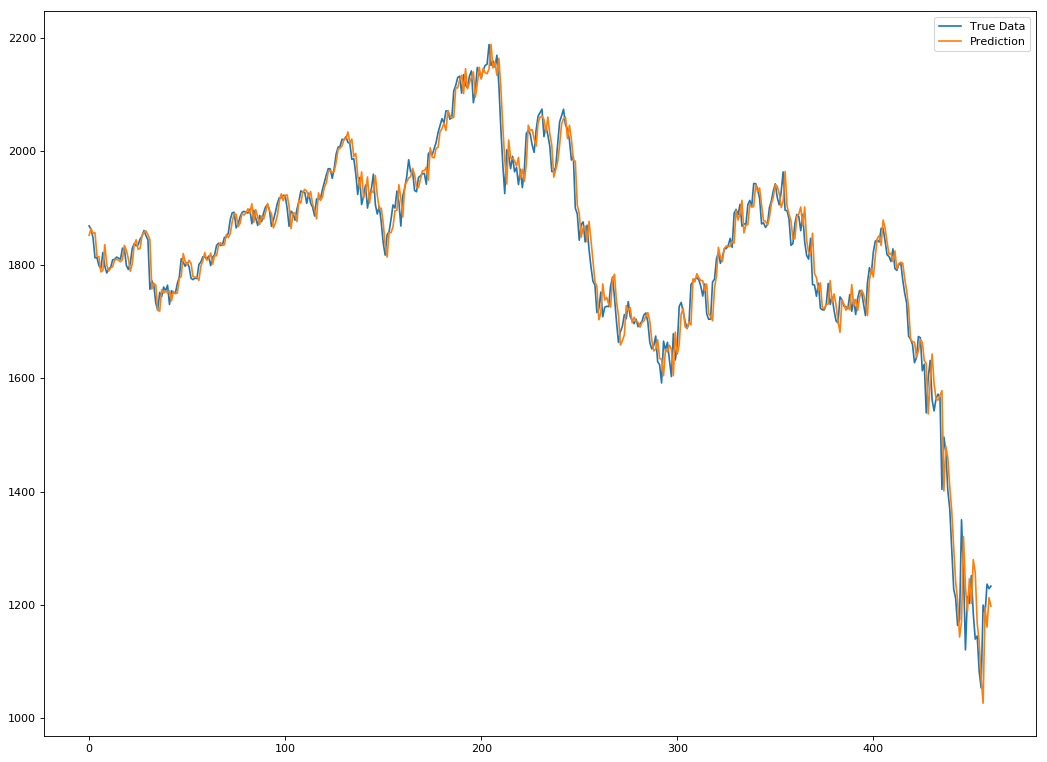

In [0]:
plot_results(predicted, original_data)

### Mean Squared Error

In [0]:
from sklearn.metrics import mean_squared_error

mean_squared_error(predicted, original_data)

1040.2207295029755

### Mean Absolute Percentage Error



In [0]:
print(np.mean(np.abs((original_data - predicted) / original_data)) * 100)

1.2965519847601614


### Convert to Directional Data

In [0]:
predicted_directions = directional_data(predicted, original_data)

No change: 236
Up: 140
Down: 84


In [0]:
actual_directions = directional_data(original_data, original_data)

No change: 96
Up: 185
Down: 179


### Plot Confusion Matrix

In [0]:
classes = ["Down", "No Change", "Up"]
classes = np.array(classes)

indices = predicted_directions.argmax(axis=1)
predicted_classes = classes[indices]

indices = actual_directions.argmax(axis=1)
y_true = classes[indices]

By Count

Confusion matrix, without normalization
[[46 81 52]
 [14 62 20]
 [24 93 68]]


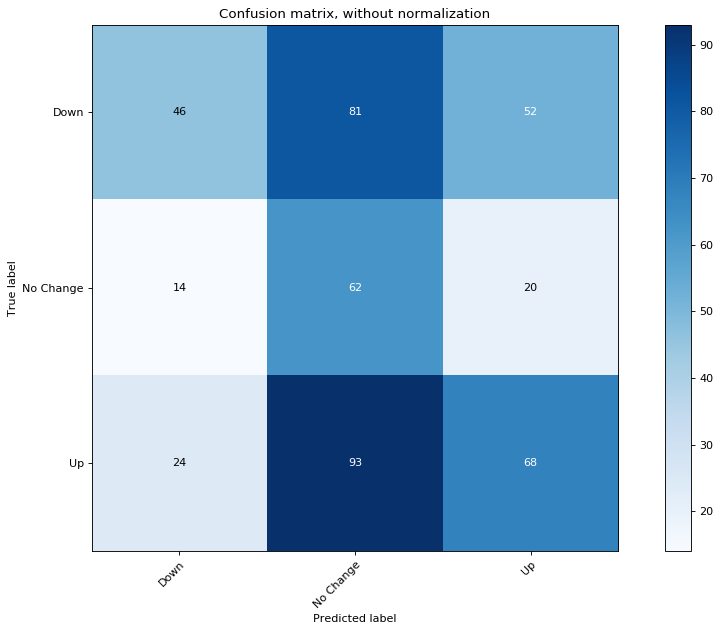

In [0]:
plot_confusion_matrix(y_true, predicted_classes, normalize=False)

Normalized

Normalized confusion matrix
[[0.25698324 0.45251397 0.29050279]
 [0.14583333 0.64583333 0.20833333]
 [0.12972973 0.5027027  0.36756757]]


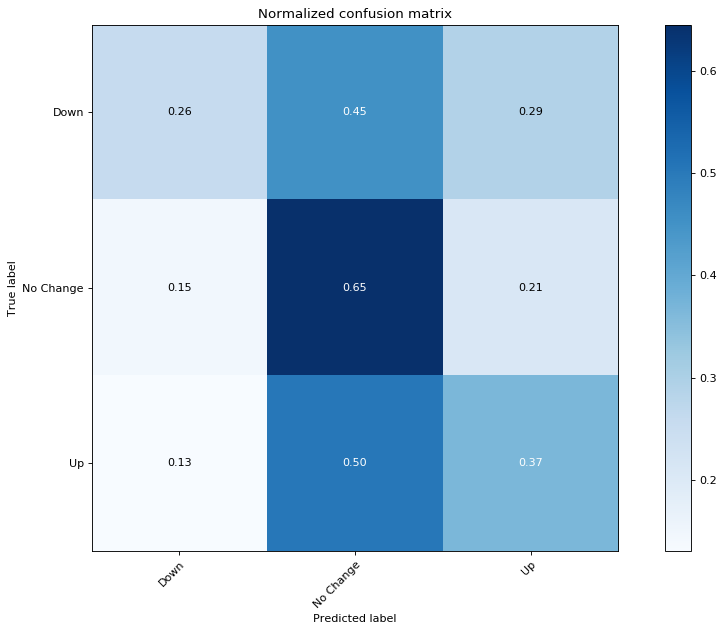

In [0]:
plot_confusion_matrix(y_true, predicted_classes, normalize=True)

### Mean Categorical Accuracy

In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, predicted_classes)

0.3826086956521739

### Export to CSV

In [0]:
y_true = np.insert(y_true, 0, 0)
predicted_classes = np.insert(predicted_classes, 0, 0)

In [0]:
columns = ['Date', 'True Closing Values', 'Predicted Closing Values', 'True Values', 'Predicted Values']
data = np.array([dates, original_data, predicted, y_true, predicted_classes]).T

In [0]:
csv = pd.DataFrame(data, columns=columns)

csv.to_csv('csc_first_half.csv', index=False)

## Download Files

In [0]:
from google.colab import files

files.download('csc_first_half.csv')

files.download('csc_first_half.h5')

## Second Half

### Load Data

In [0]:
x_train_2, y_train_2, x_test_2, y_test_2, scalars_2, original_data_2, dates_2 = load_data(df.values[int(len(df)/2):], seq_len, all_data[int(len(df)/2):])

x_train_2 = np.transpose(x_train_2, (1,2,0))
x_test_2 = np.transpose(x_test_2, (1,2,0))

### Convolutional Sparse Coding

In [0]:
D0 = np.random.randn(filter_length, x_train_2.shape[1], num_filters)
lmbda = 0.05
opt = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True, 'MaxMainIter': 10,
                        'CBPDN': {'rho': 50.0*lmbda + 0.5},
                        'CCMOD': {'rho': 10.0}},
                        dmethod='cns')
csc_2 = cbpdndl.ConvBPDNDictLearn(D0, x_train_2, lmbda, opt, dmethod='cns', dimK=None, dimN=1)
D1 = csc_2.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  8.55e+03  9.05e+02  1.53e+05  3.82e-15  3.22e-01  2.71e+00  3.00e+00  1.02e-01  7.94e-02  1.00e+01
   1  7.85e+03  3.91e+01  1.56e+05  4.08e-15  2.22e-01  1.10e+00  3.00e+00  7.76e-02  1.86e-02  1.00e+01
   2  7.09e+03  2.01e+02  1.38e+05  3.87e-15  1.68e-01  5.73e-01  3.00e+00  6.52e-02  1.23e-01  1.00e+01
   3  6.96e+03  1.10e+02  1.37e+05  4.22e-15  1.36e-01  4.64e-01  3.00e+00  4.85e-02  3.79e-02  1.00e+01
   4  6.27e+03  8.12e+01  1.24e+05  3.92e-15  1.09e-01  4.23e-01  3.00e+00  4.08e-02  9.63e-02  1.00e+01
   5  5.96e+03  1.16e+02  1.17e+05  4.03e-15  8.24e-02  3.60e-01  3.00e+00  3.17e-02  1.14e-01  1.00e+01
   6  5.78e+03  8.97e+01  1.14e+05  3.70e-15  6.78e-02  3.30e-01  3.00e+00  2.60e-02  6.03e-02  1.00e+01
   7  5.48e+03  7.88e+01  1.08e+05  4.15e-15  5.58e-02 

### Reconstruction

#### Training Data

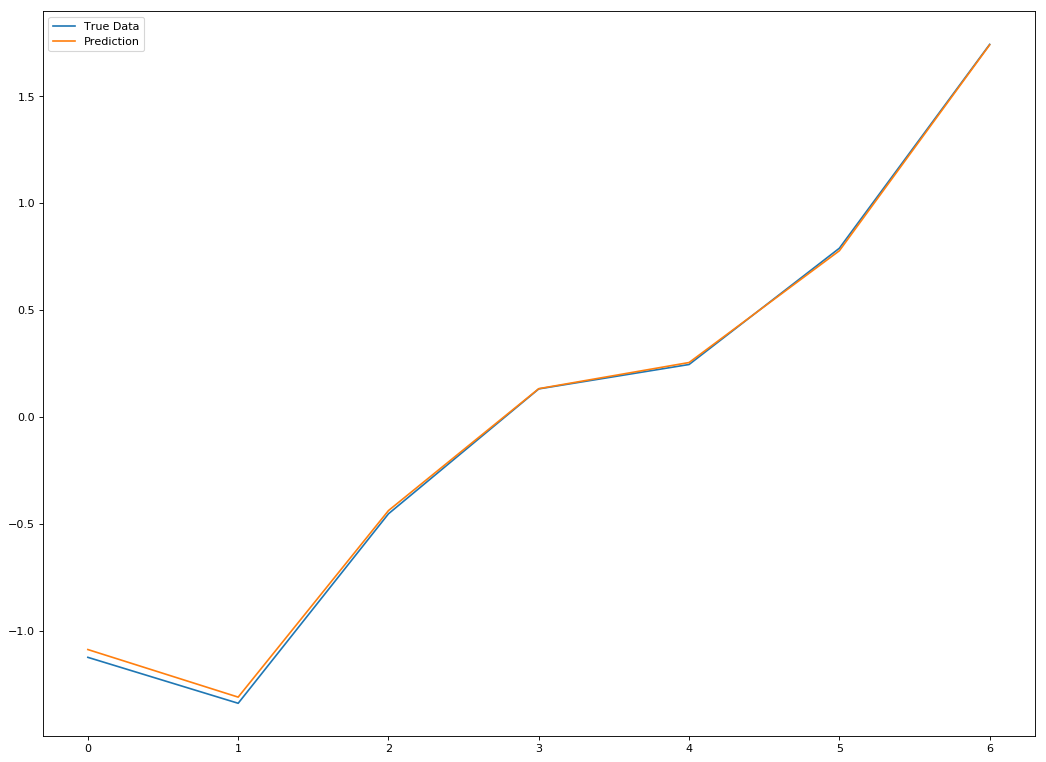

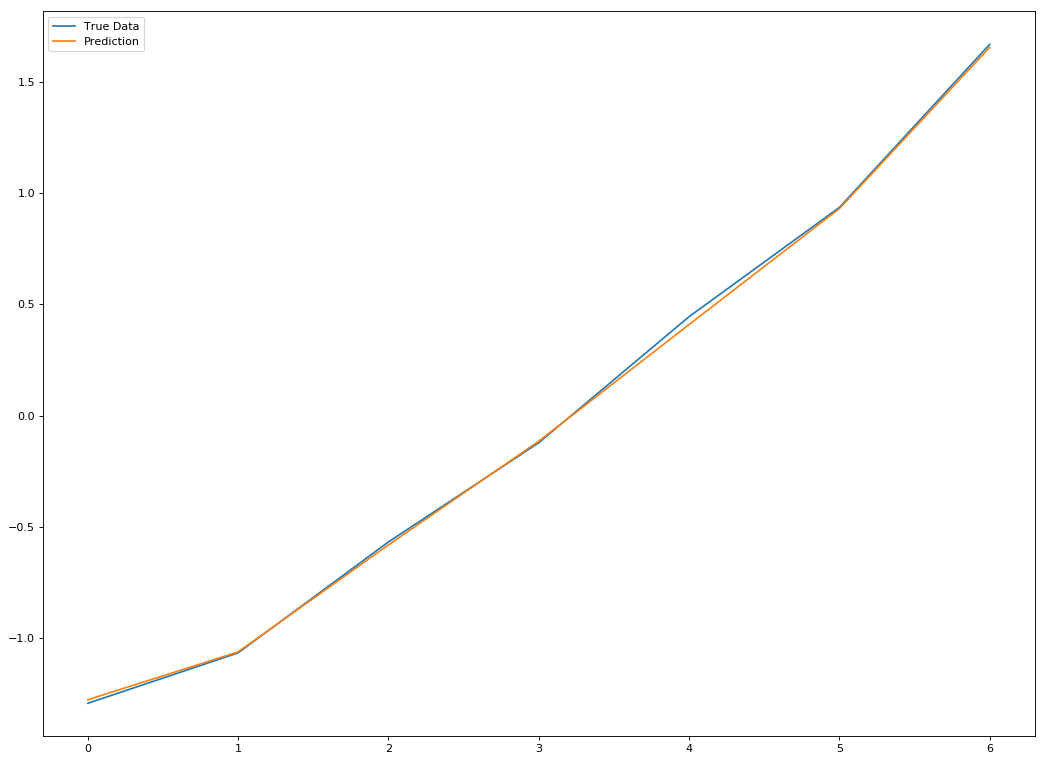

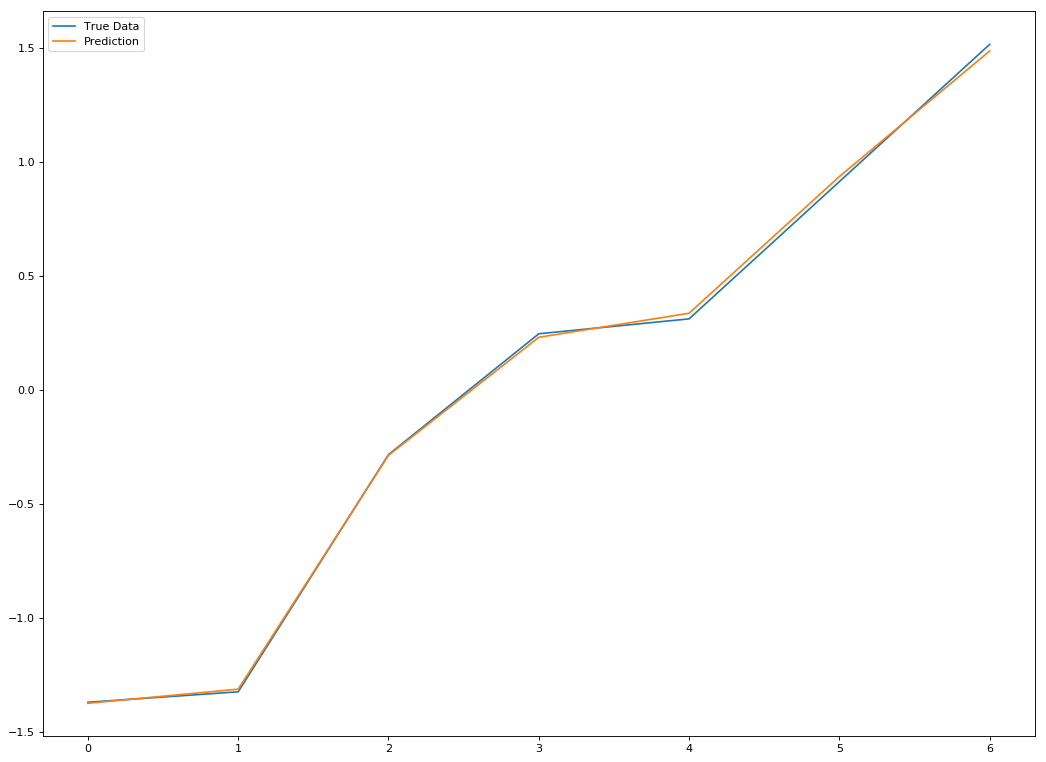

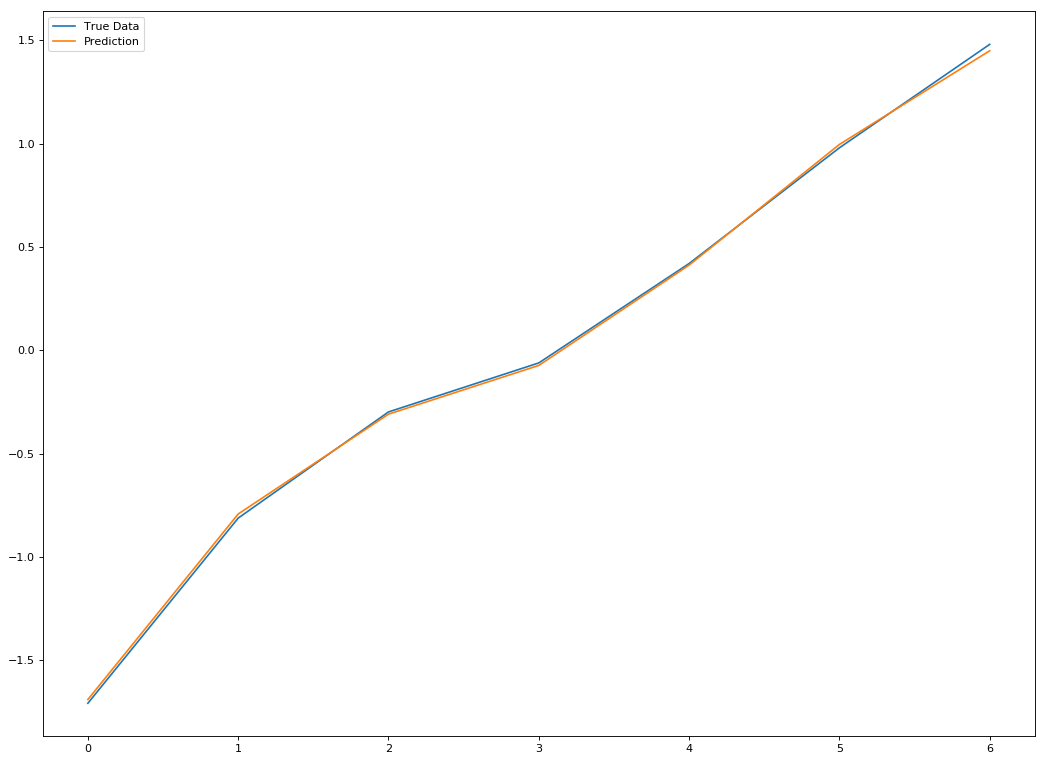

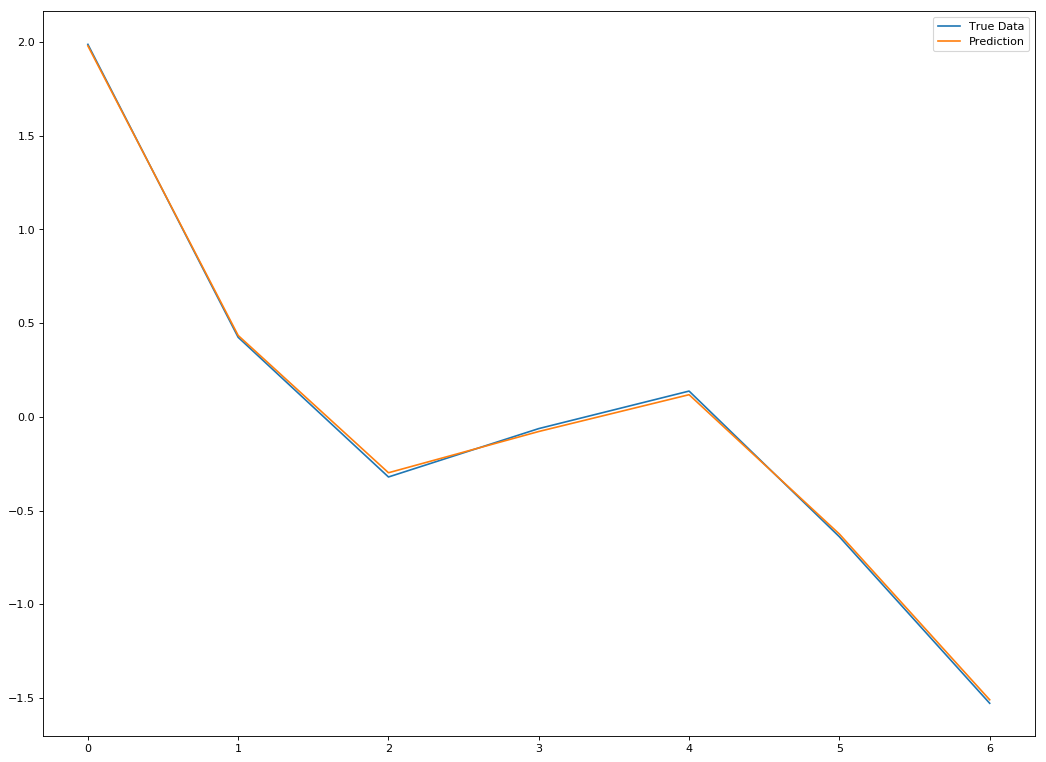

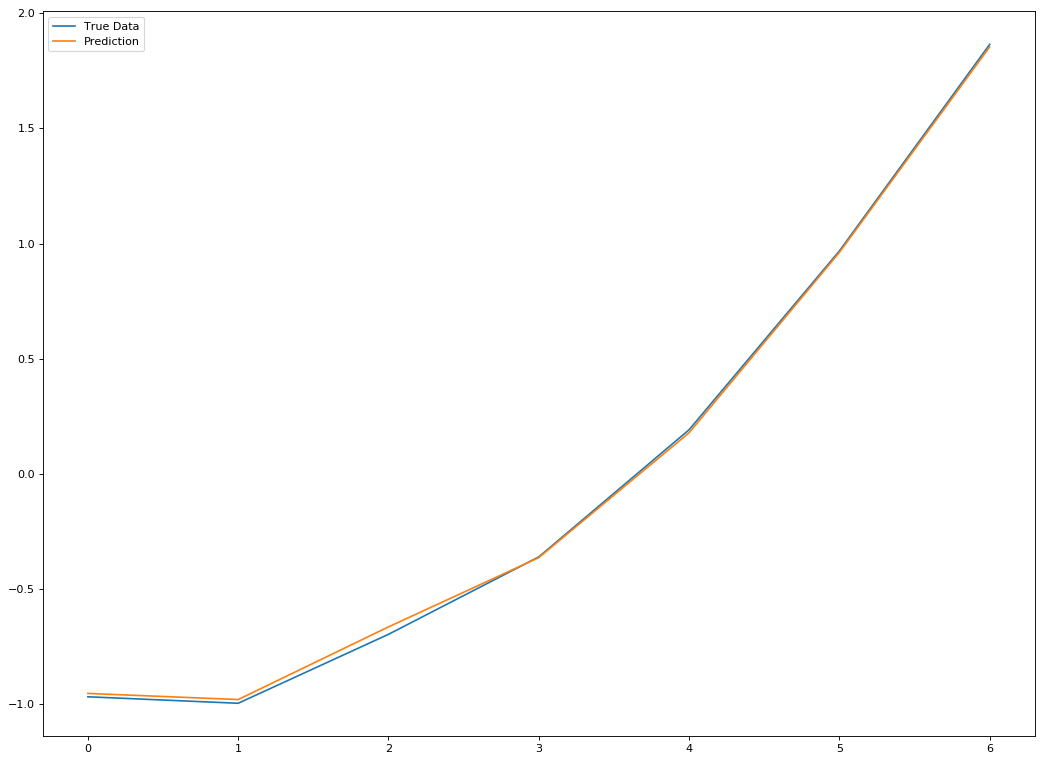

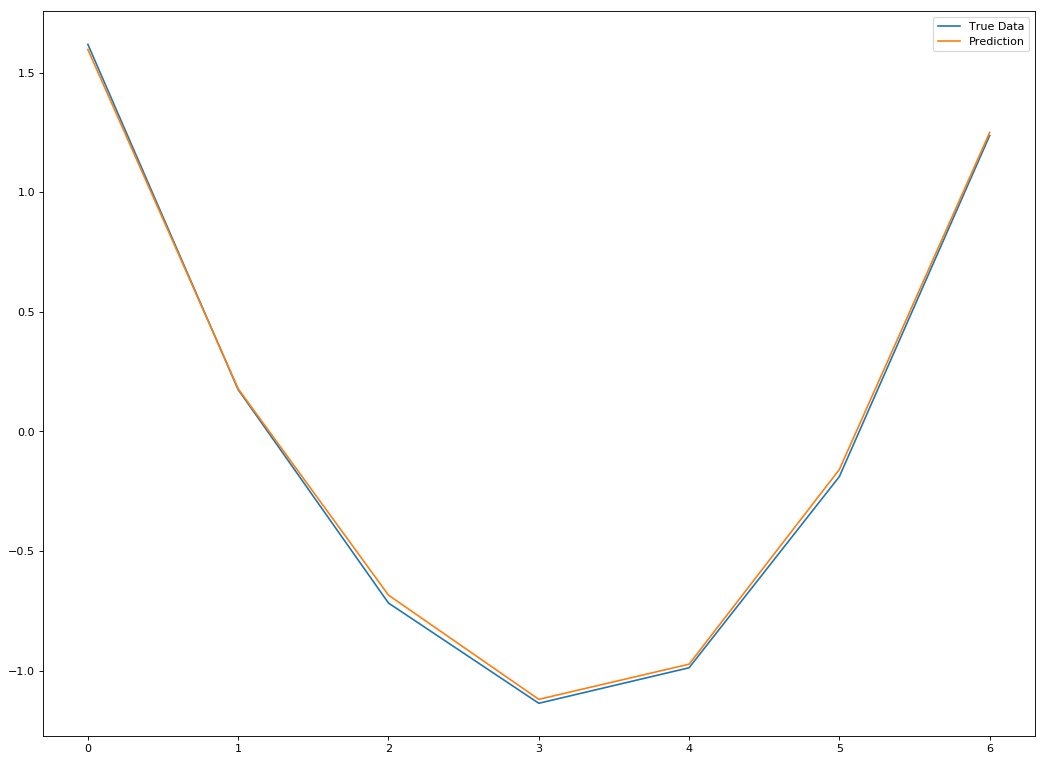

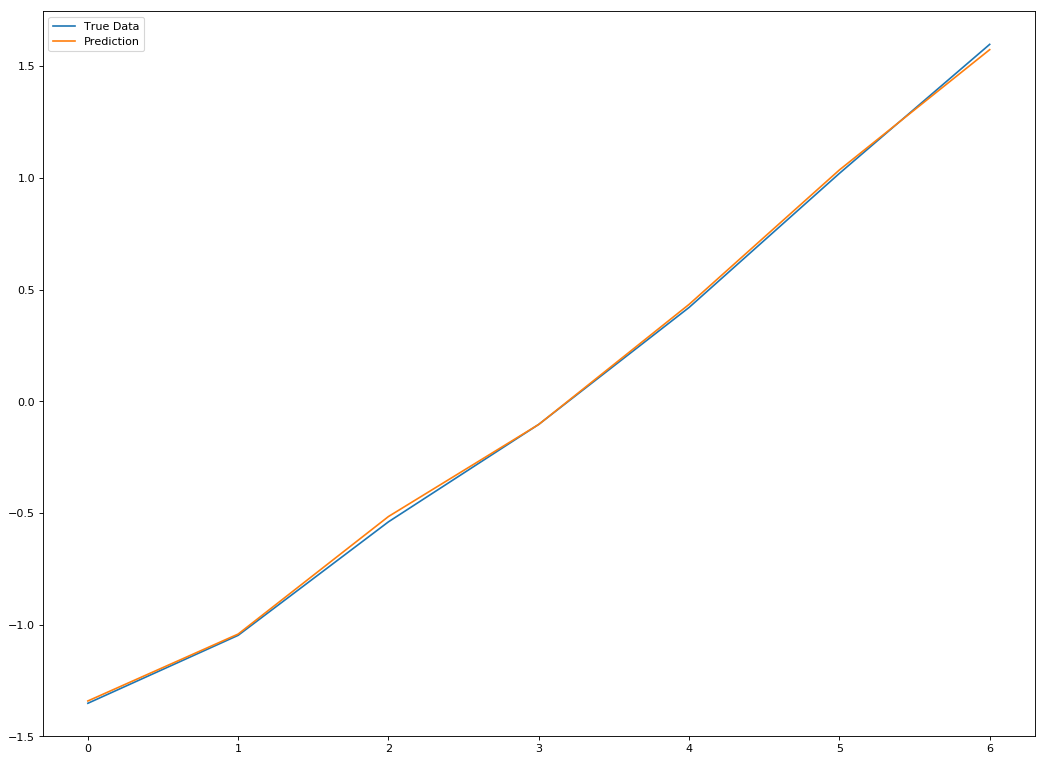

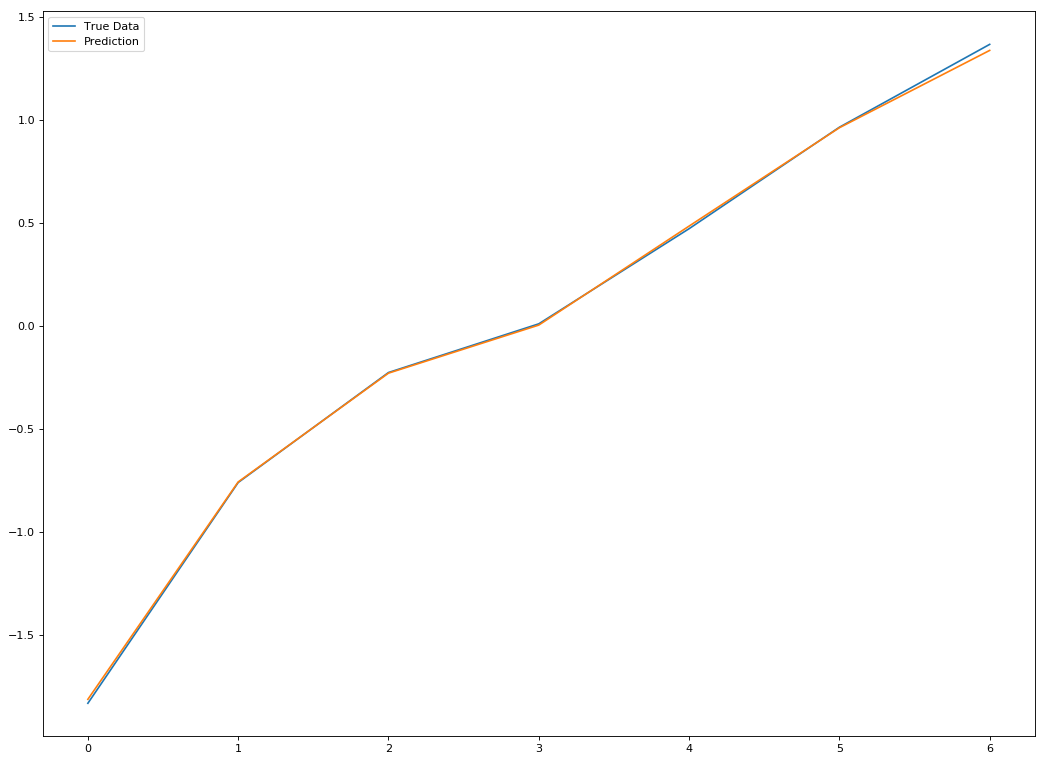

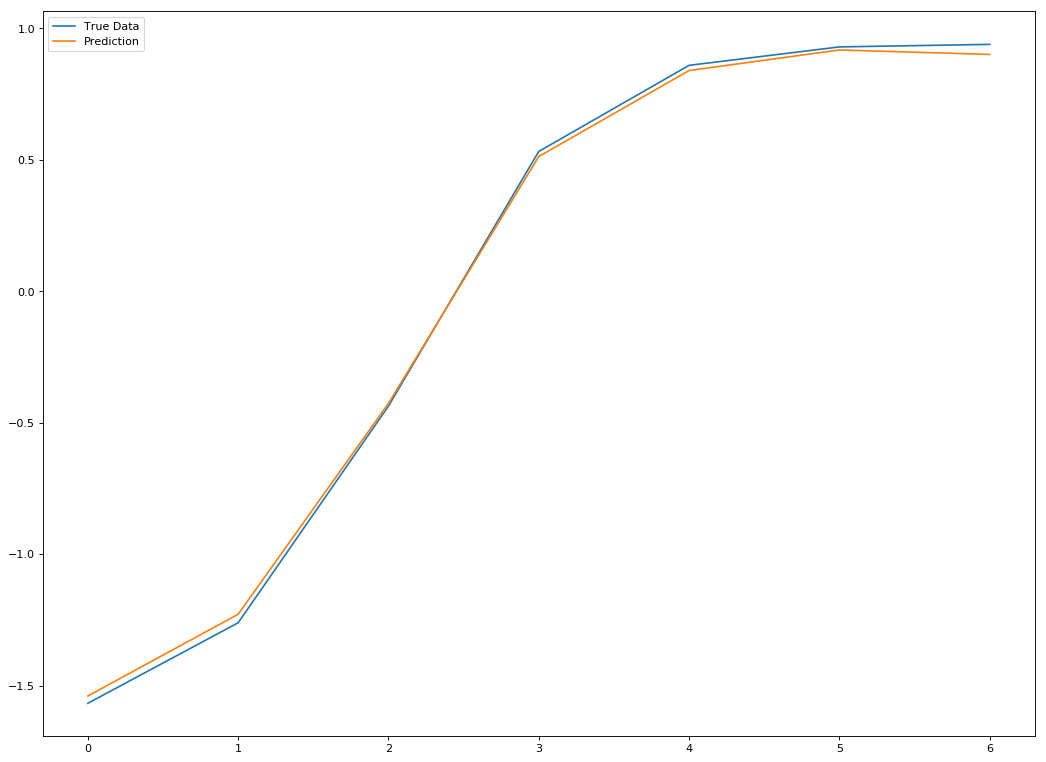

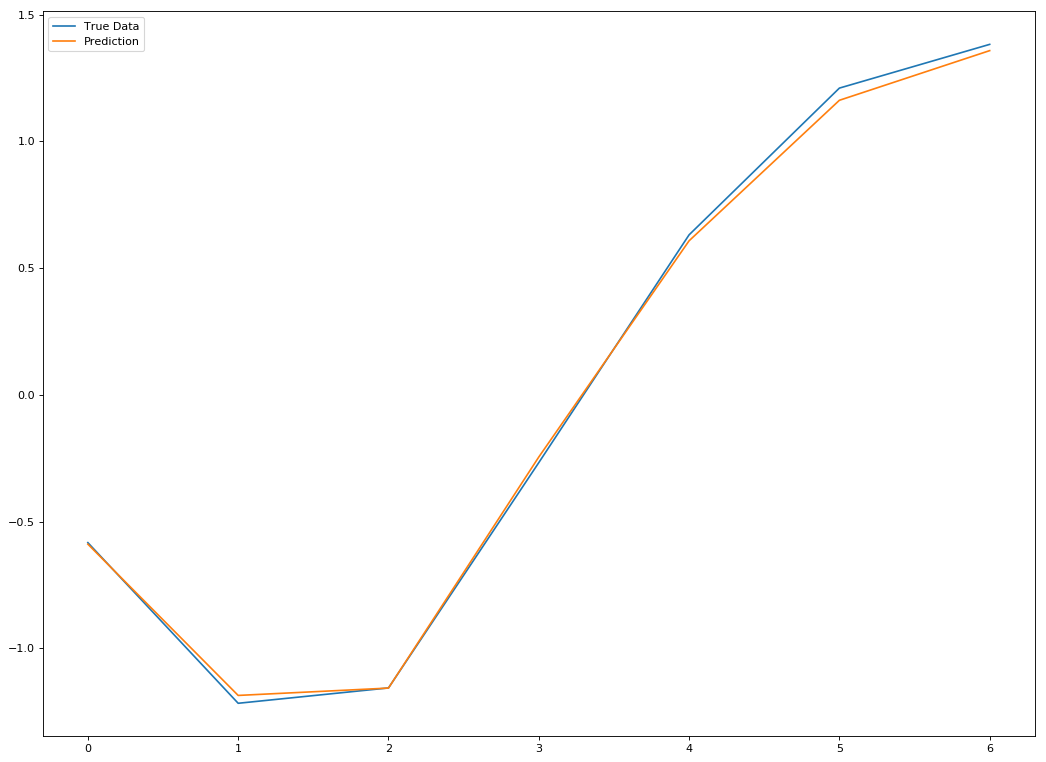

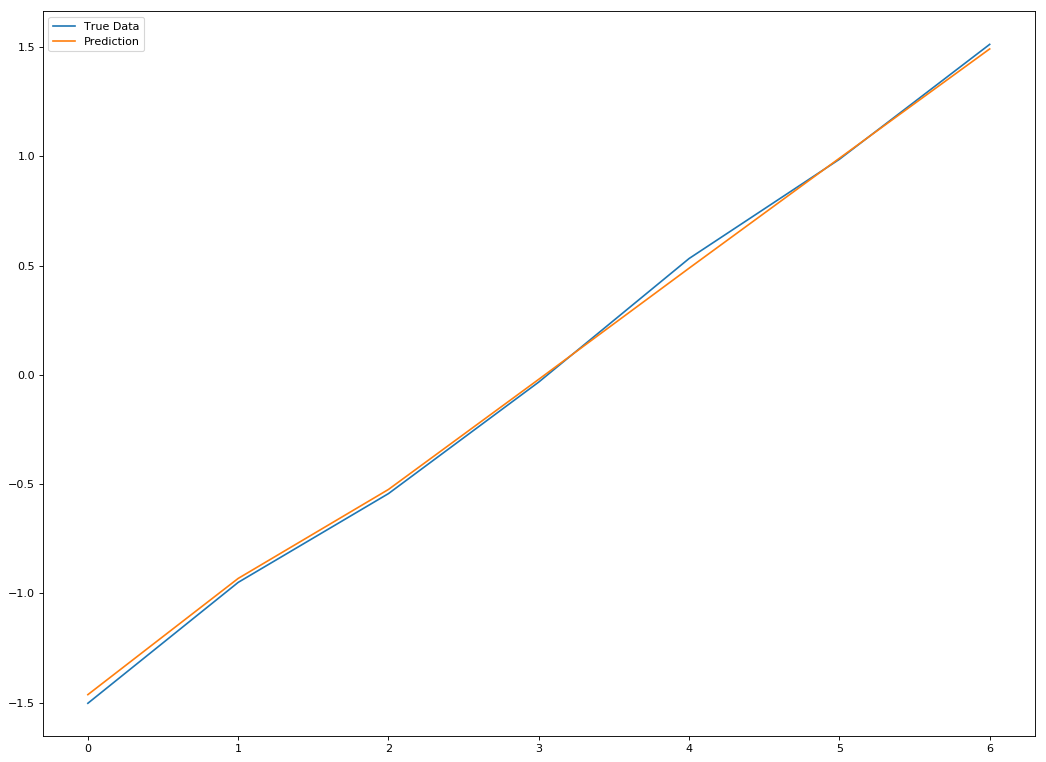

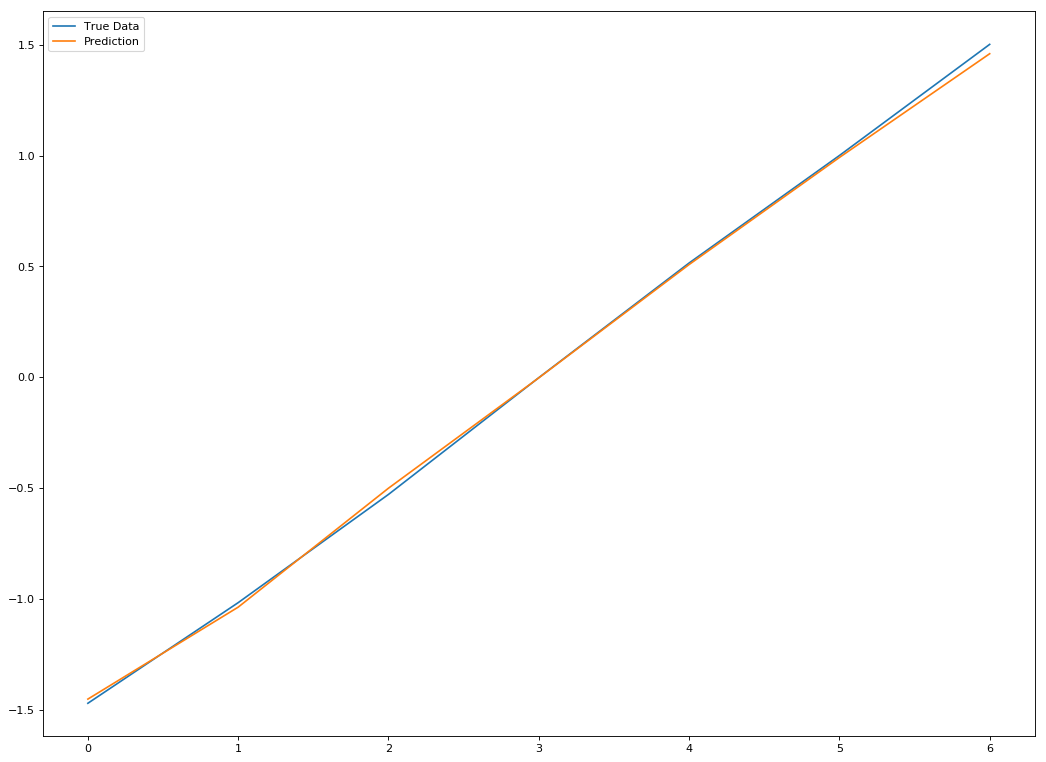

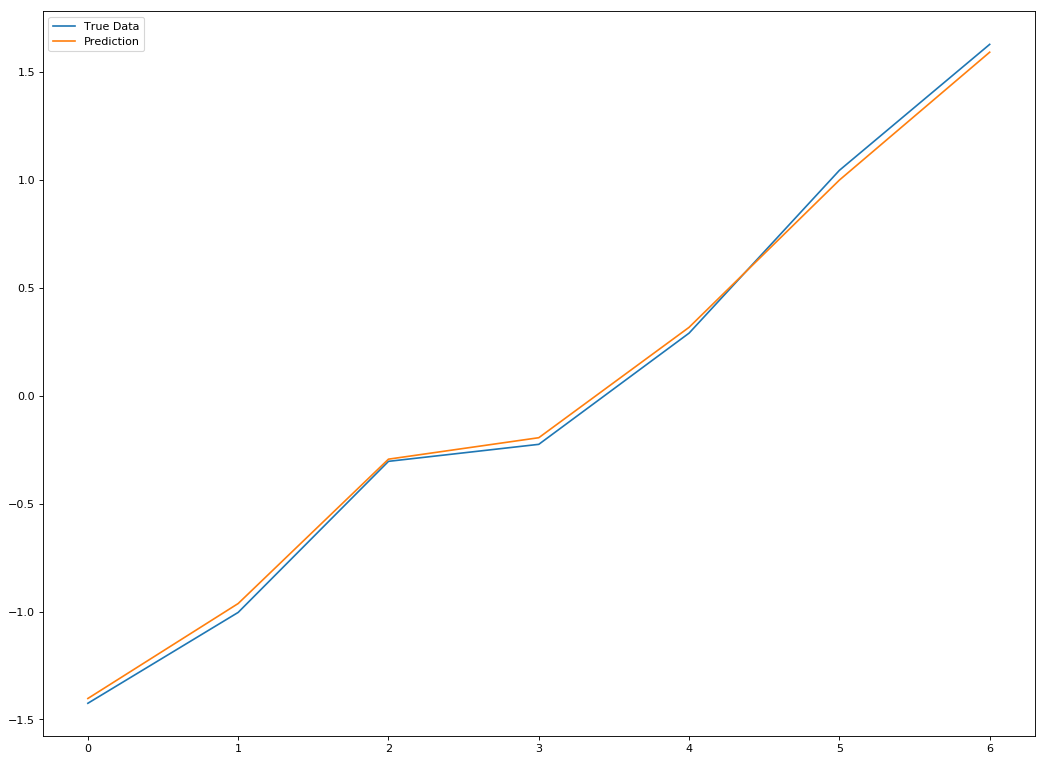

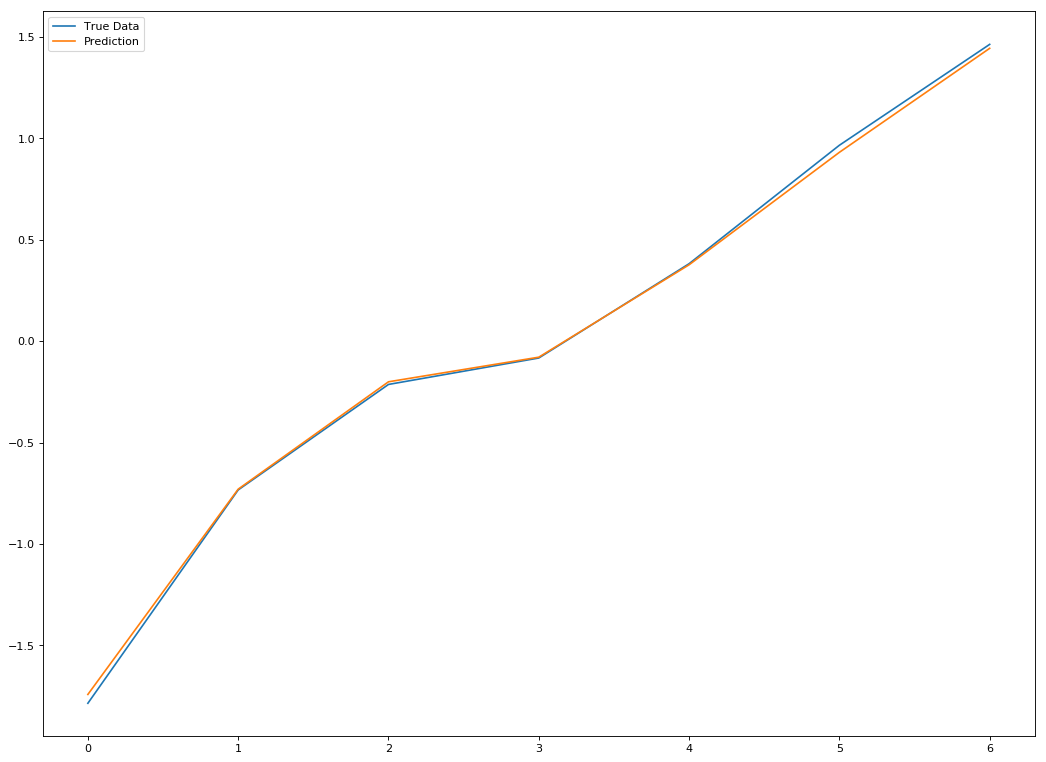

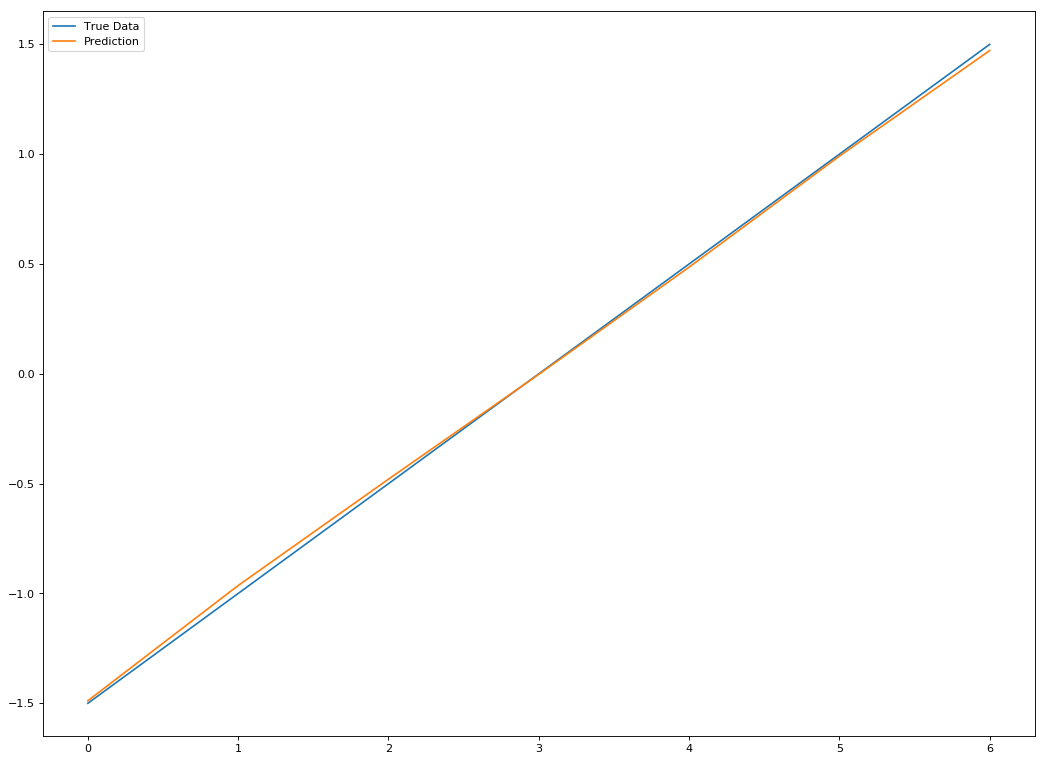

In [0]:
reconstructed_train_2 = csc_2.reconstruct().squeeze()

for i in range(x_train_2.shape[1]):
  plot_results(reconstructed_train_2[:,i,0], x_train_2[:,i,0])

In [0]:
x_train_2 = csc_2.getcoef()

#### Testing Data

In [0]:
D1 = np.array(D1)
D1 = D1.reshape(D1.shape[0], D1.shape[1], -1)

In [0]:
csc_2 = cbpdndl.ConvBPDNDictLearn(D1, x_test_2, lmbda, opt, dmethod='cns', dimK=None, dimN=1)
D1 = csc_2.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  2.07e+03  2.04e+02  3.74e+04  3.77e-15  3.22e-01  2.65e+00  3.00e+00  1.02e-01  8.57e-02  1.00e+01
   1  1.91e+03  9.40e+00  3.80e+04  4.08e-15  2.24e-01  1.08e+00  3.00e+00  7.76e-02  1.60e-02  1.00e+01
   2  1.72e+03  4.58e+01  3.35e+04  3.78e-15  1.71e-01  5.66e-01  3.00e+00  6.52e-02  1.20e-01  1.00e+01
   3  1.69e+03  2.64e+01  3.33e+04  4.23e-15  1.37e-01  4.62e-01  3.00e+00  4.84e-02  4.59e-02  1.00e+01
   4  1.52e+03  1.89e+01  3.00e+04  3.58e-15  1.09e-01  4.26e-01  3.00e+00  4.08e-02  8.76e-02  1.00e+01
   5  1.45e+03  2.72e+01  2.84e+04  4.05e-15  8.31e-02  3.58e-01  3.00e+00  3.16e-02  1.07e-01  1.00e+01
   6  1.41e+03  2.15e+01  2.77e+04  3.87e-15  6.80e-02  3.28e-01  3.00e+00  2.60e-02  4.70e-02  1.00e+01
   7  1.33e+03  1.86e+01  2.63e+04  4.16e-15  5.59e-02 

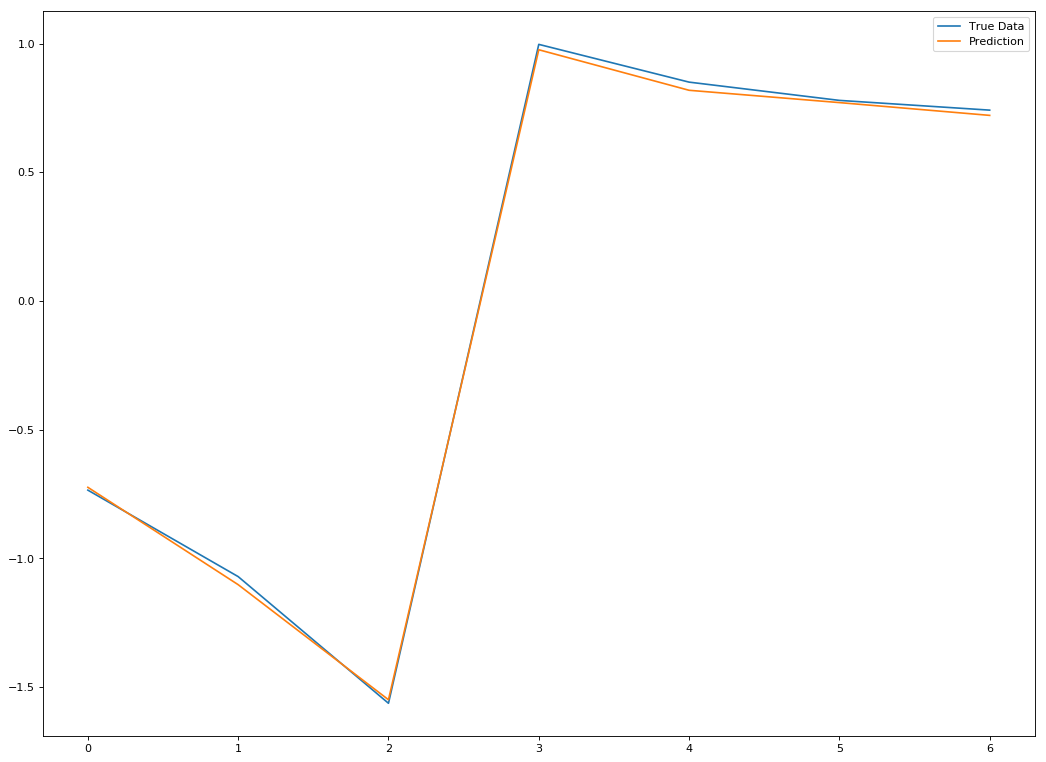

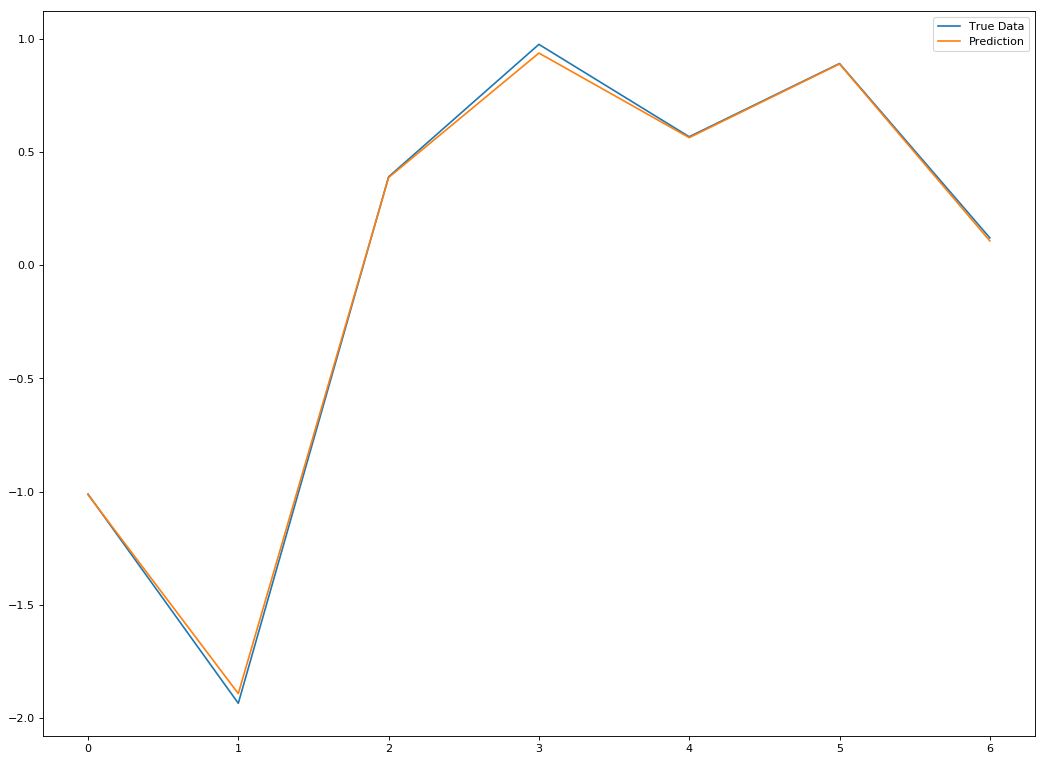

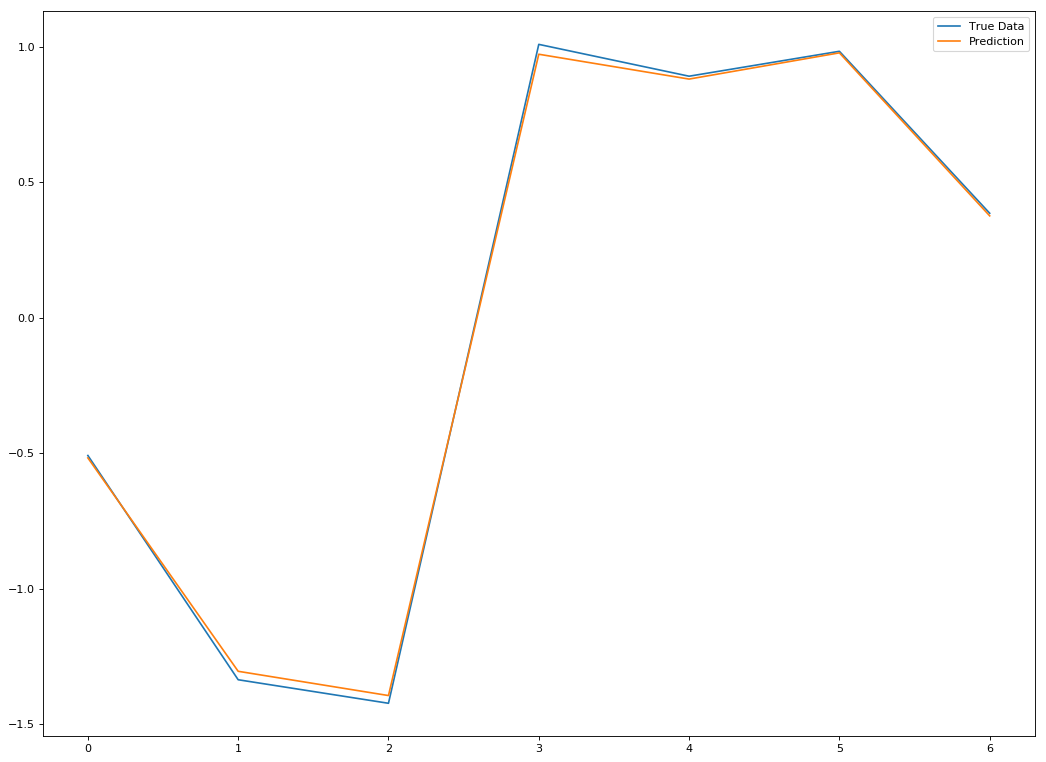

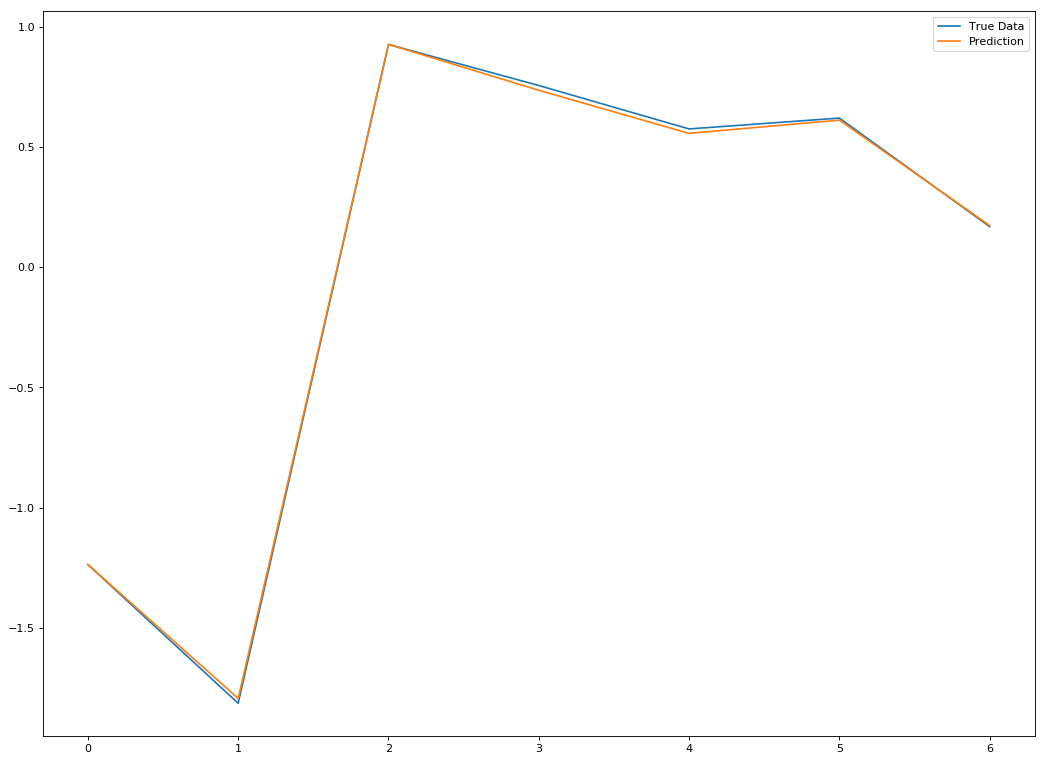

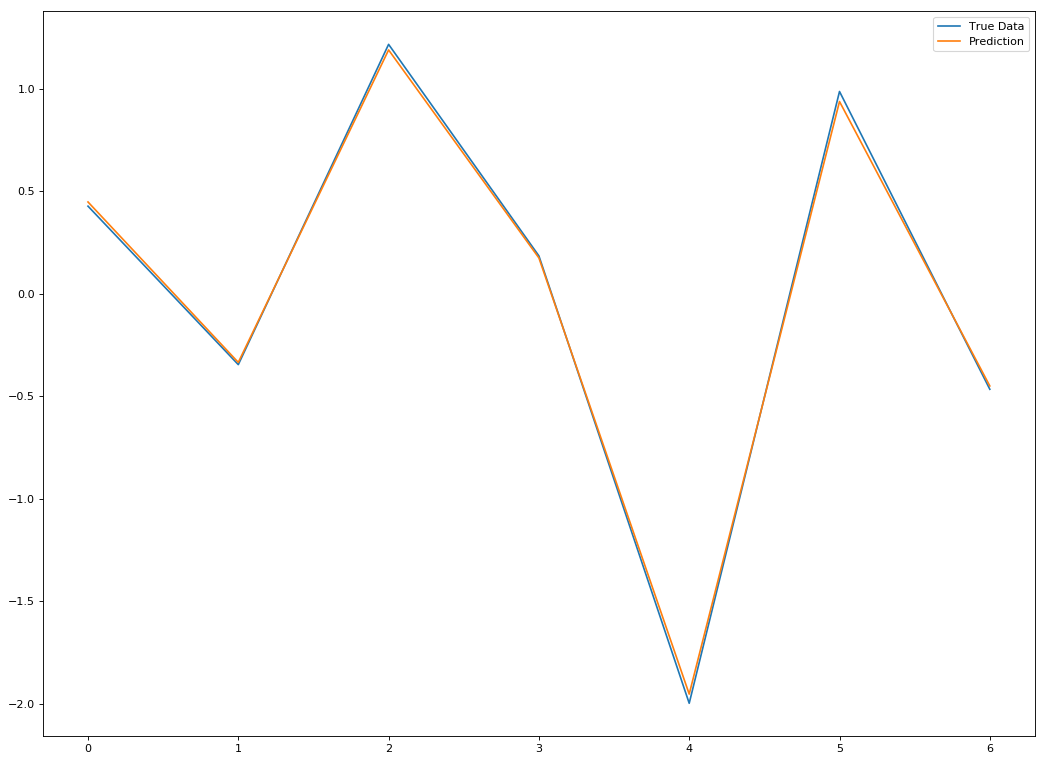

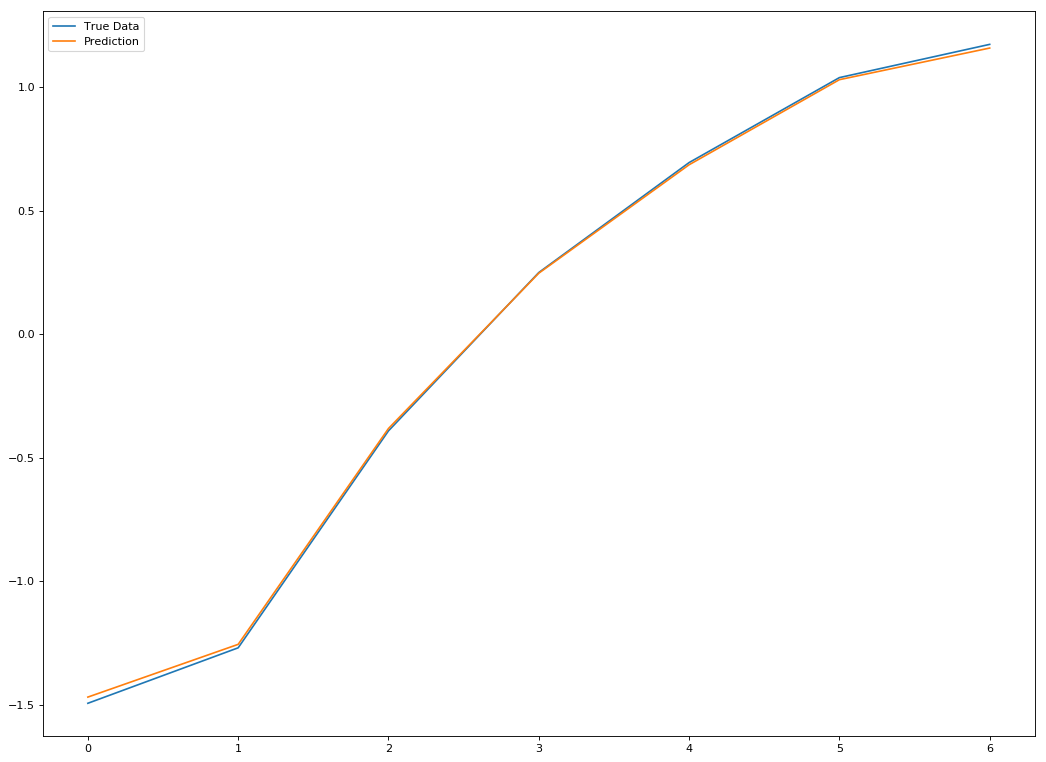

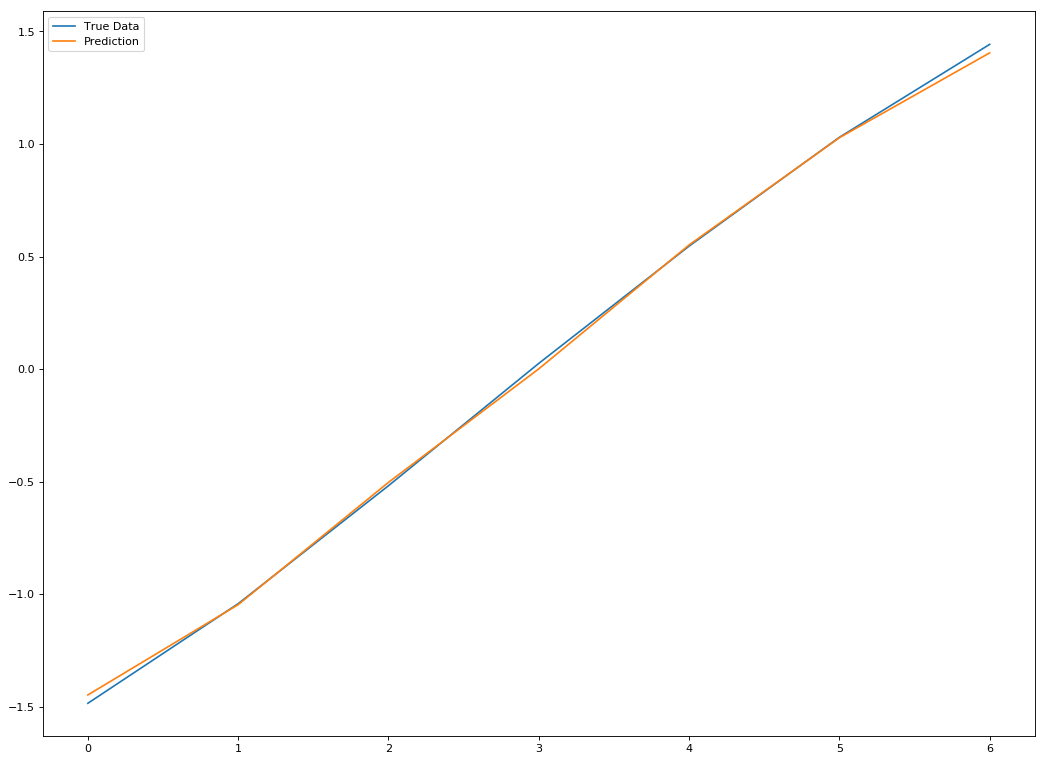

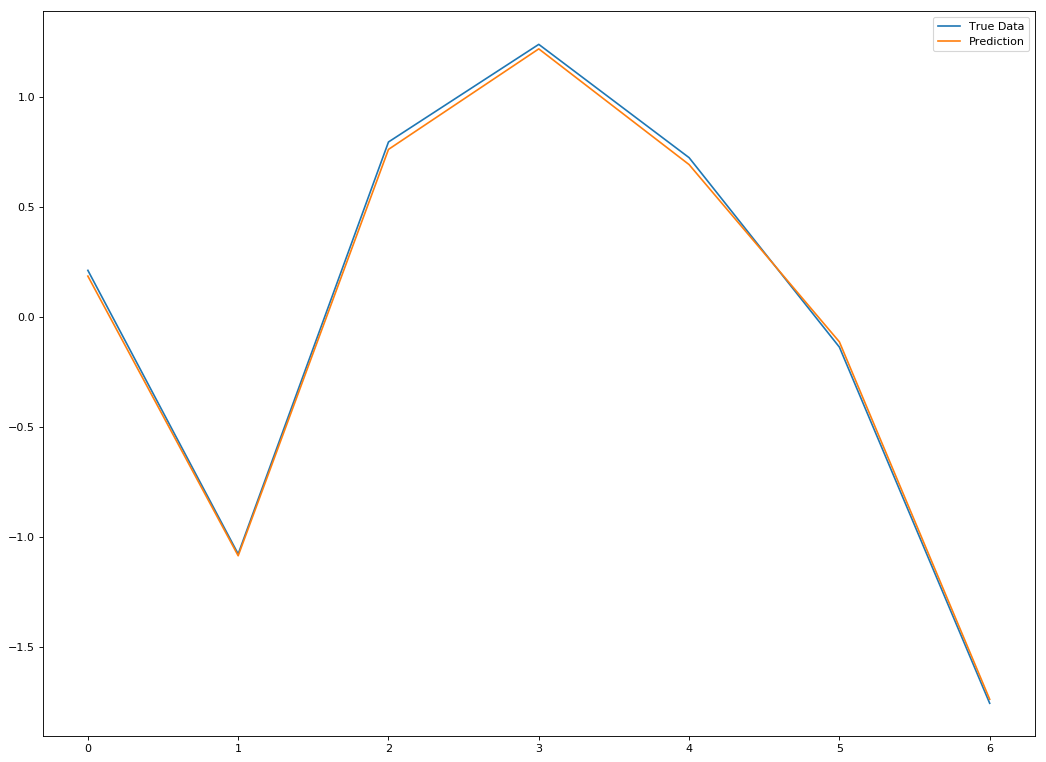

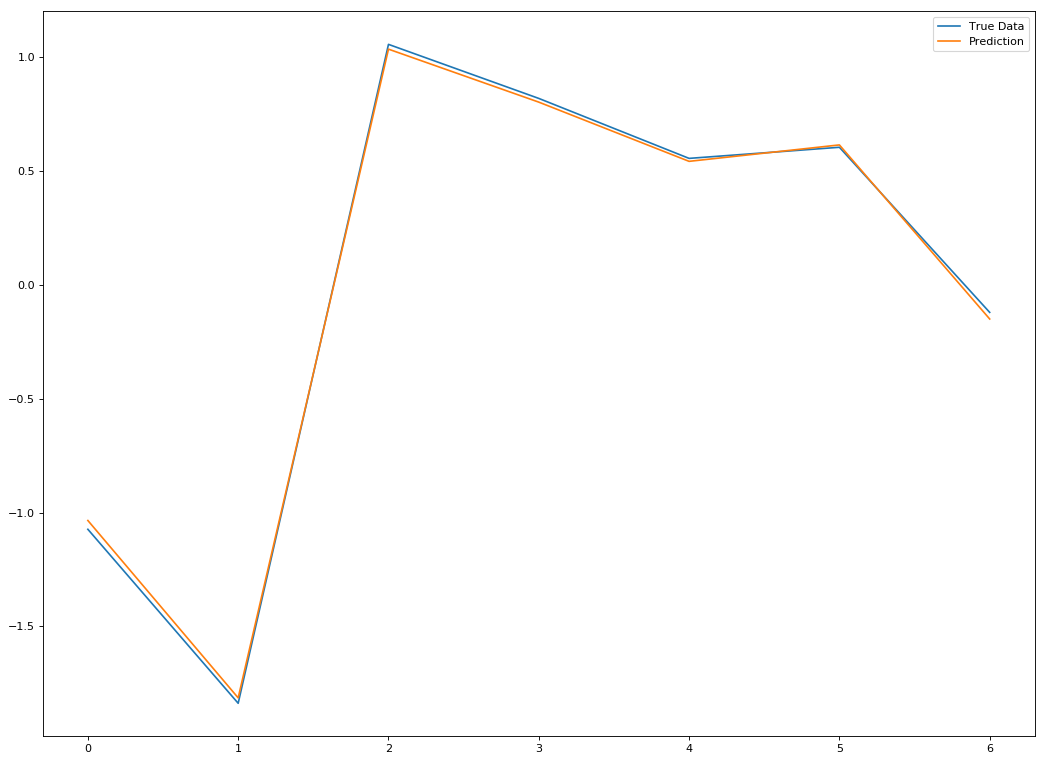

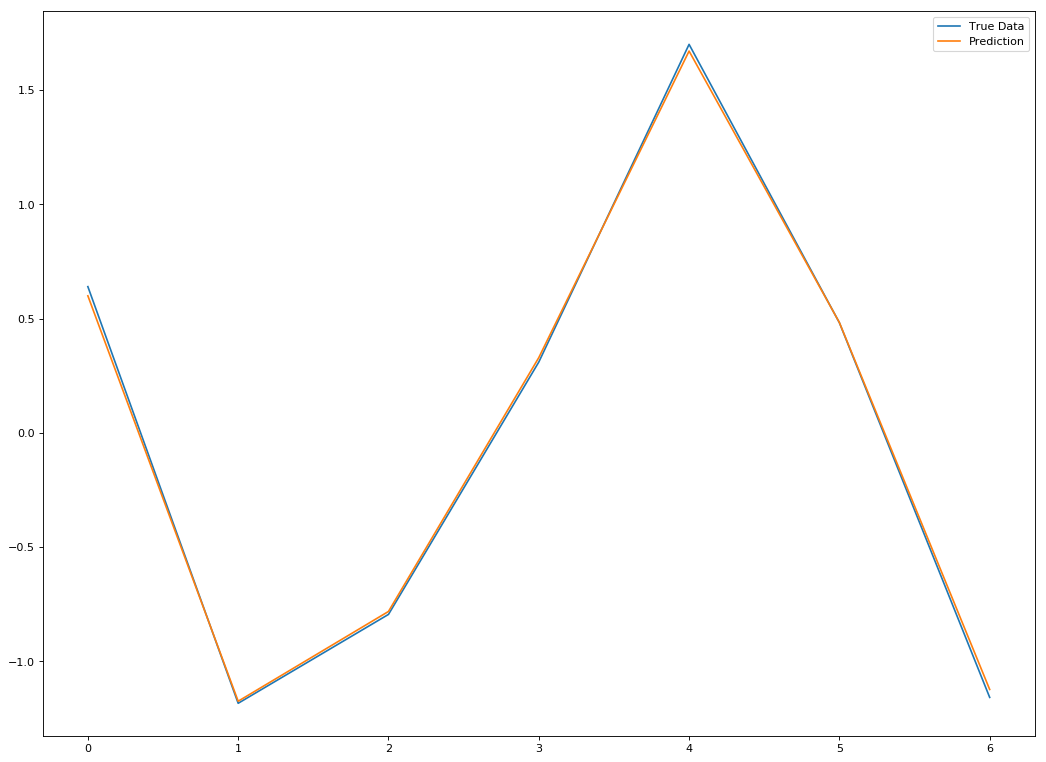

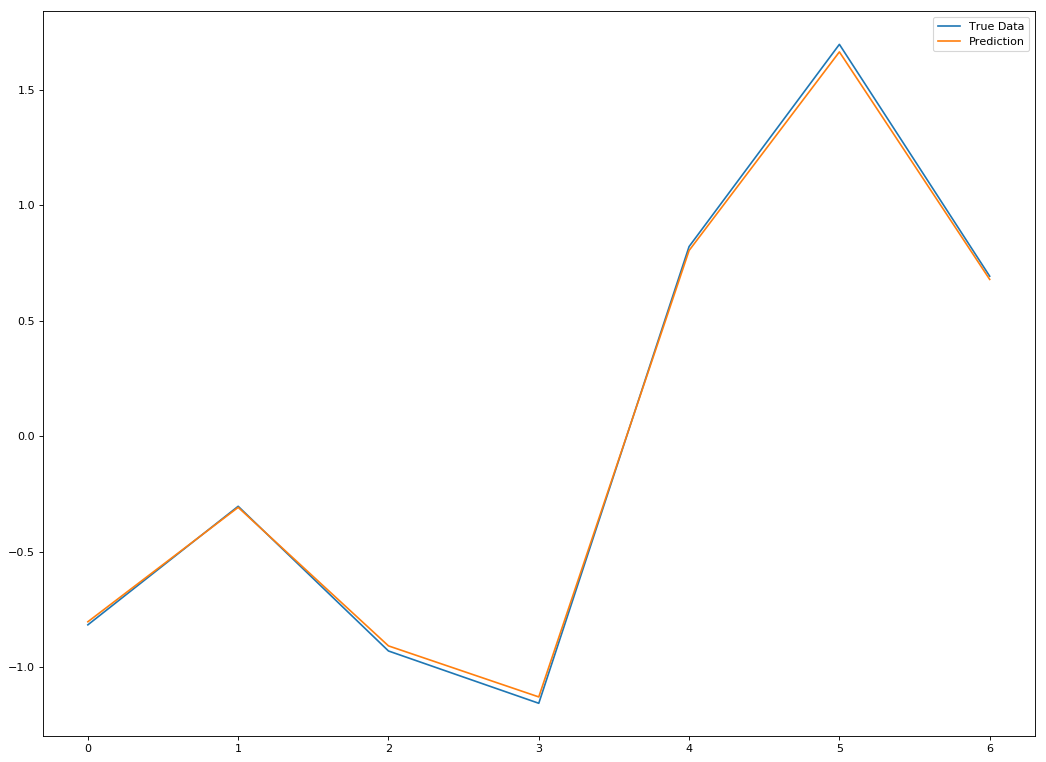

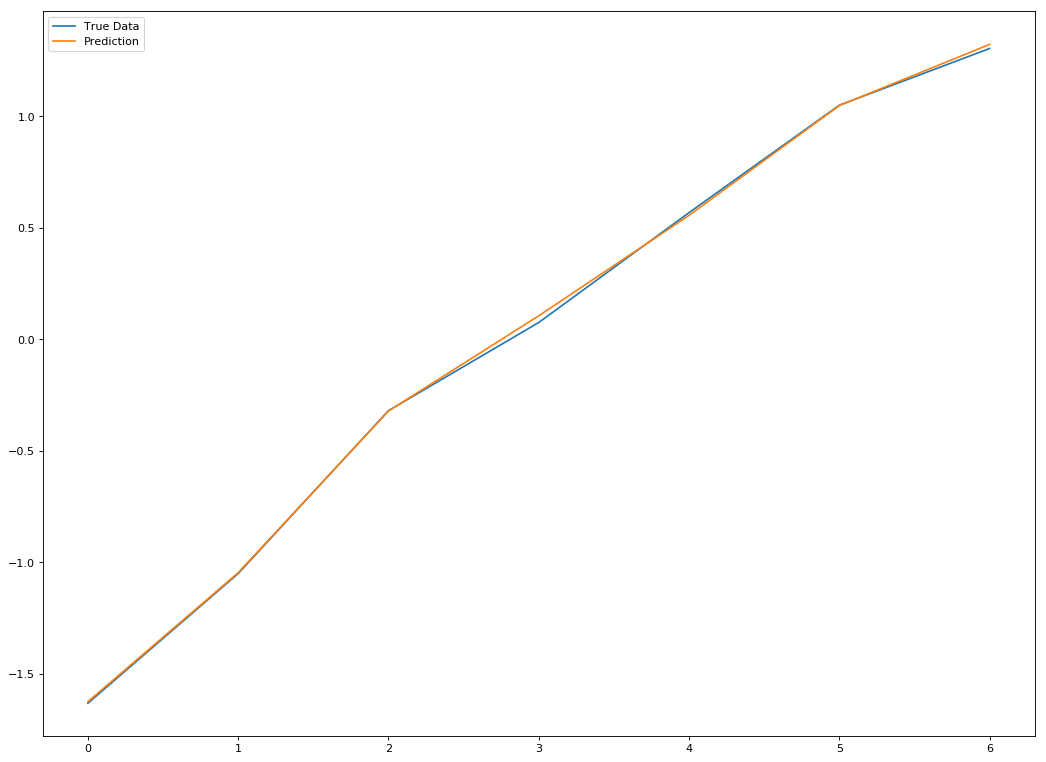

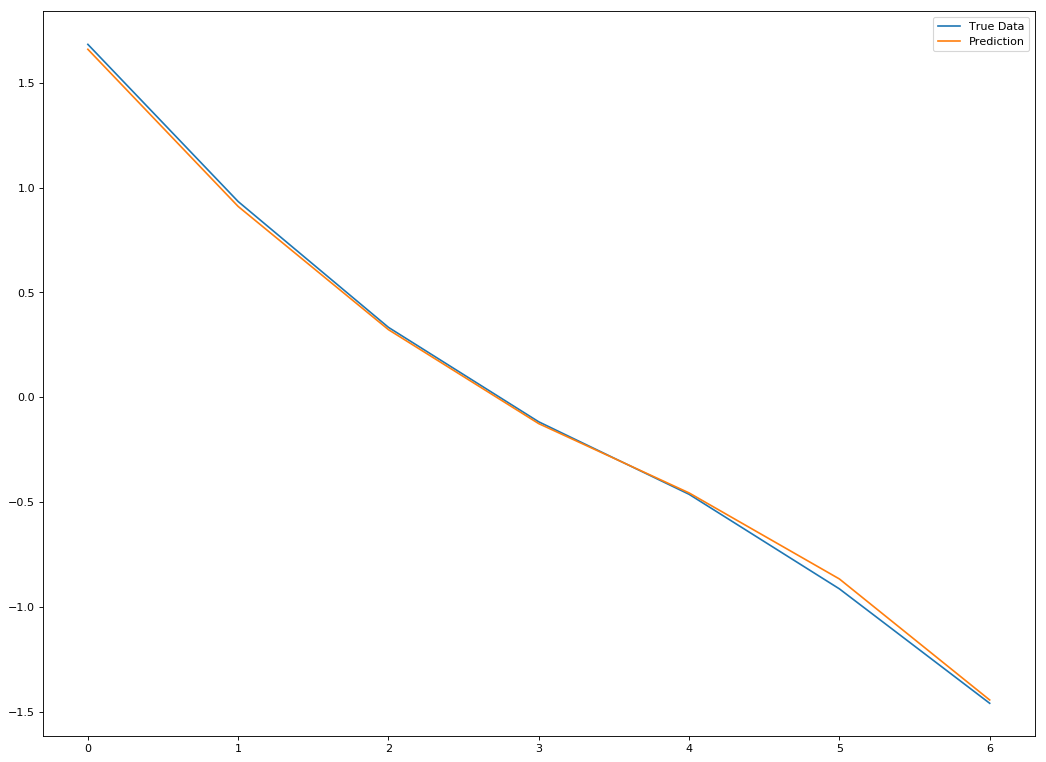

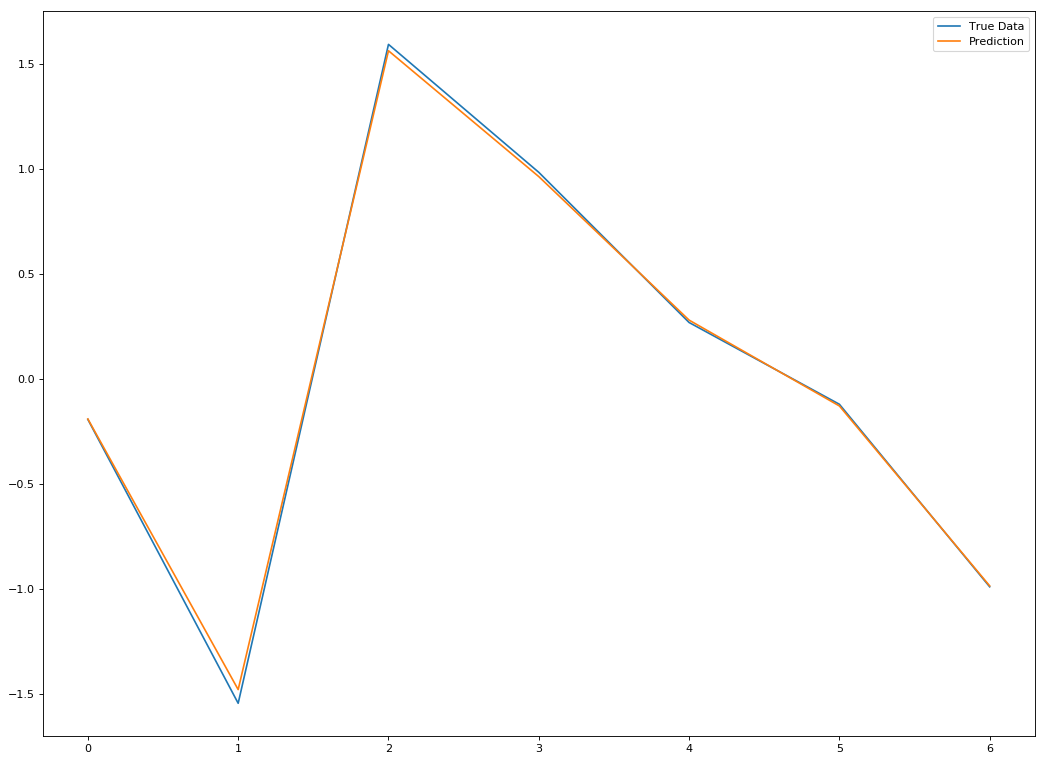

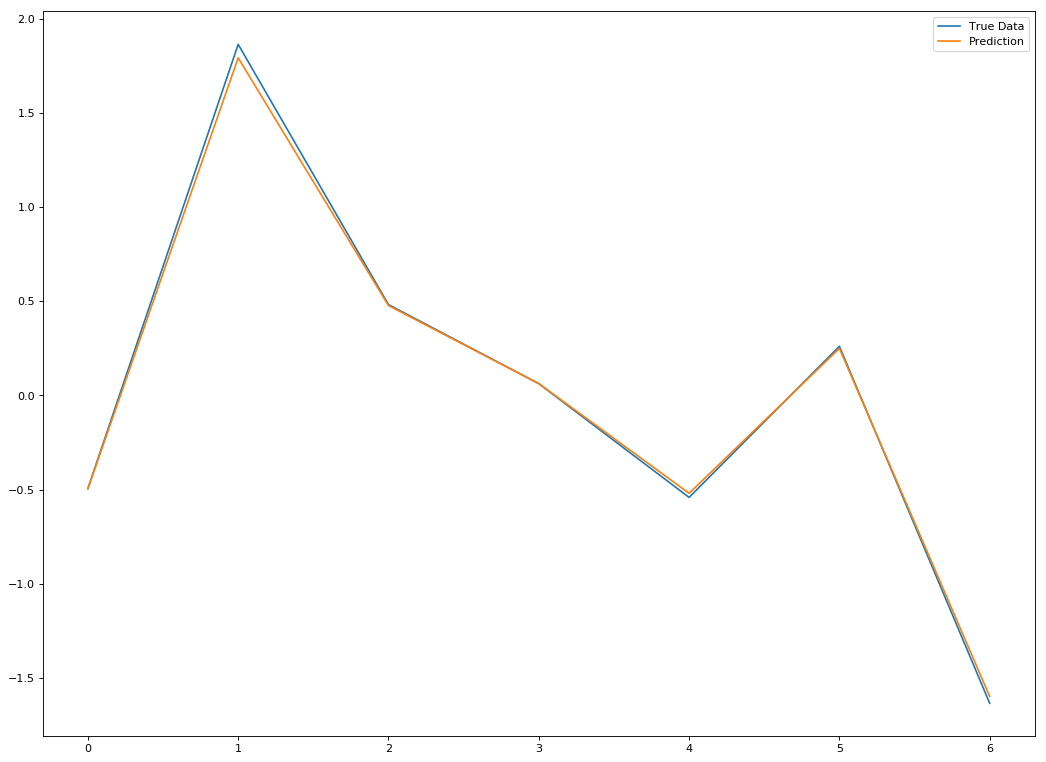

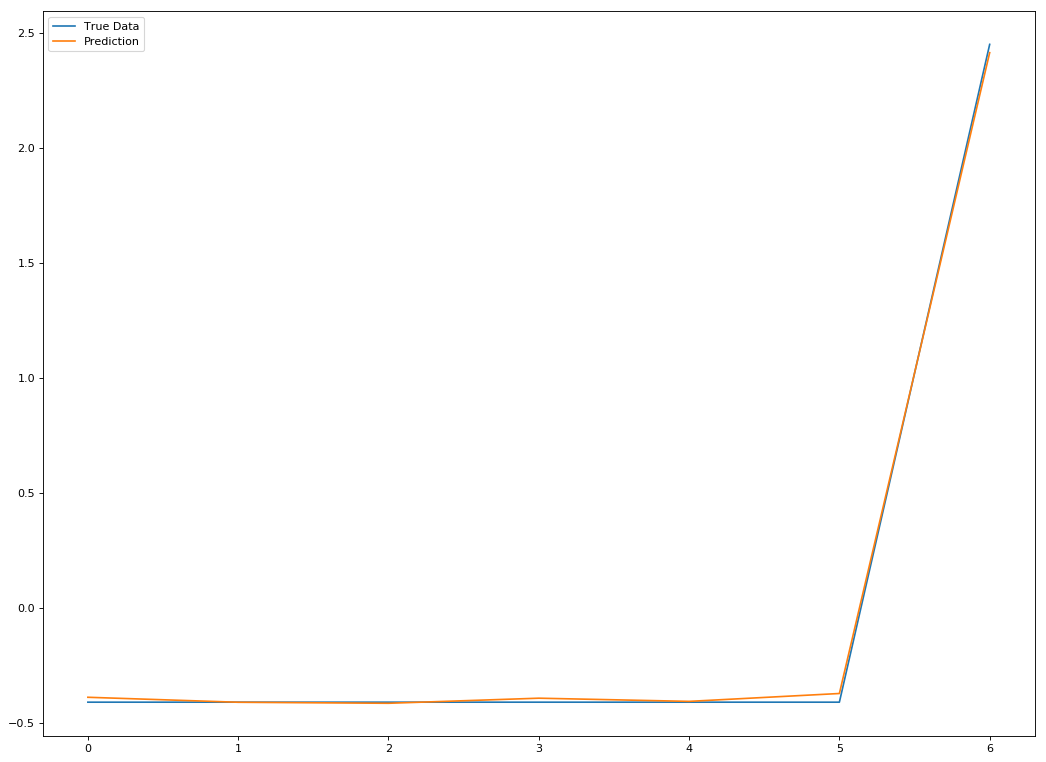

In [0]:
reconstructed_test_2 = csc_2.reconstruct().squeeze()
for i in range(x_test_2.shape[1]):
  plot_results(reconstructed_test_2[:,i,0], x_test_2[:,i,0])

In [0]:
x_test_2 = csc_2.getcoef()

### Show Dictionary

In [0]:
D1 = np.array(D1)
D1 = D1.reshape(D1.shape[0], D1.shape[1], -1)

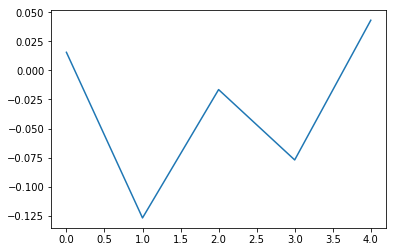

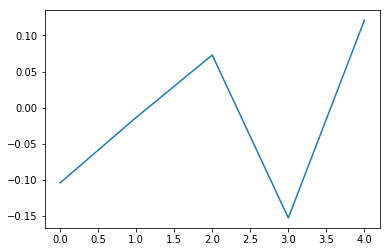

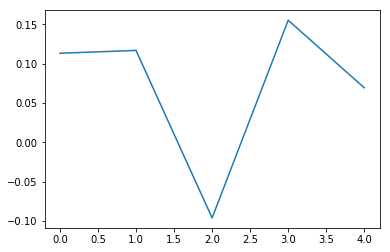

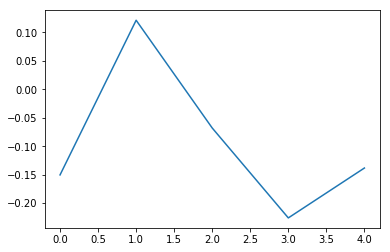

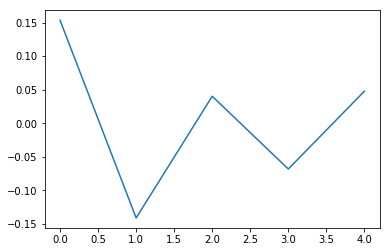

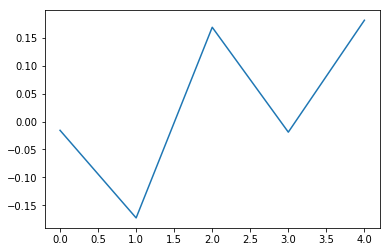

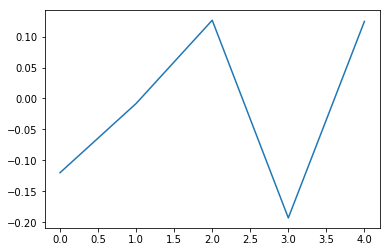

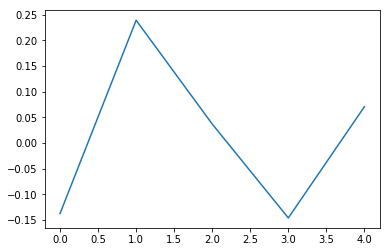

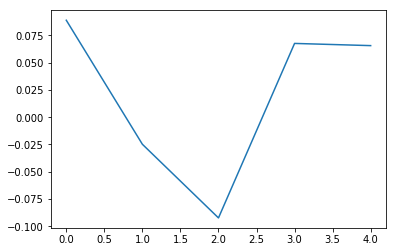

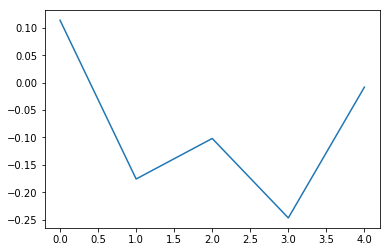

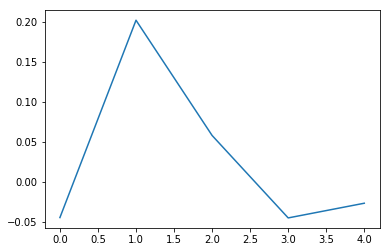

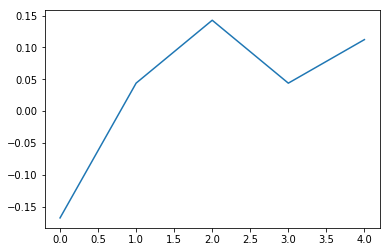

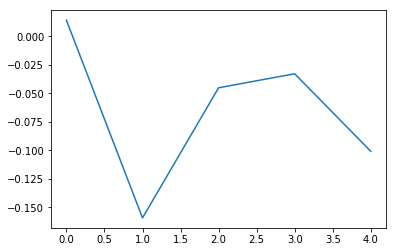

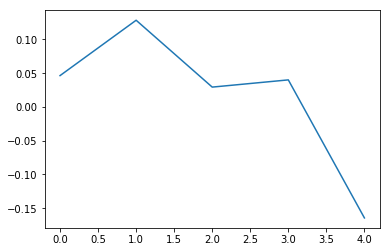

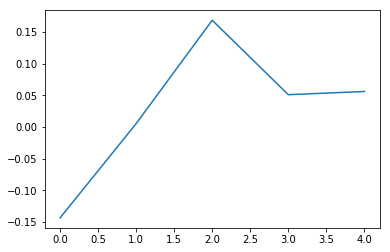

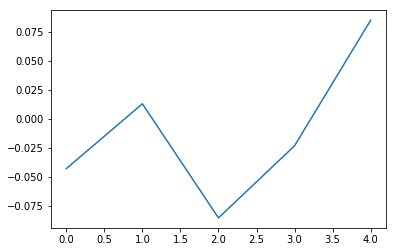

In [0]:
for i in range(D1.shape[1]):
  plt.plot(D1[:,i,0])
  plt.show()

### Create Prediction Model

In [0]:
x_train_2 = x_train_2.reshape(x_train_2.shape[0],x_train_2.shape[2],-1)
x_test_2 = x_test_2.reshape(x_test_2.shape[0],x_test_2.shape[2],-1)

x_train_2 = np.transpose(x_train_2, (1,0,2))
x_test_2 = np.transpose(x_test_2, (1,0,2))

In [0]:
model_2 = create_model(x_train_2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 7, 500)            0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 3500)              0         
_________________________________________________________________
dense_63 (Dense)             (None, 10)                35010     
_________________________________________________________________
dense_64 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_65 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 11        
Total params: 35,241
Trainable params: 35,241
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [0]:
callbacks_list = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]

history = model_2.fit(x_train_2,
                      y_train_2,
                      batch_size=256,
                      epochs=5000,
                      shuffle=True,
                      callbacks=callbacks_list,
                      validation_split=0.1,
                      verbose=1)

model_2.save('csc_second_half.h5')

Train on 1661 samples, validate on 185 samples
Epoch 1/5000
1661/1661 [==============================] - 2s 970us/sample - loss: 3.4339 - val_loss: 3.4175
Epoch 2/5000
1661/1661 [==============================] - 0s 56us/sample - loss: 3.2322 - val_loss: 3.1576
Epoch 3/5000
1661/1661 [==============================] - 0s 55us/sample - loss: 3.0571 - val_loss: 2.9201
Epoch 4/5000
1661/1661 [==============================] - 0s 54us/sample - loss: 2.9004 - val_loss: 2.7286
Epoch 5/5000
1661/1661 [==============================] - 0s 54us/sample - loss: 2.7641 - val_loss: 2.5508
Epoch 6/5000
1661/1661 [==============================] - 0s 55us/sample - loss: 2.6185 - val_loss: 2.3865
Epoch 7/5000
1661/1661 [==============================] - 0s 56us/sample - loss: 2.4851 - val_loss: 2.2386
Epoch 8/5000
1661/1661 [==============================] - 0s 56us/sample - loss: 2.3585 - val_loss: 2.1019
Epoch 9/5000
1661/1661 [==============================] - 0s 54us/sample - loss: 2.2304 - val_lo

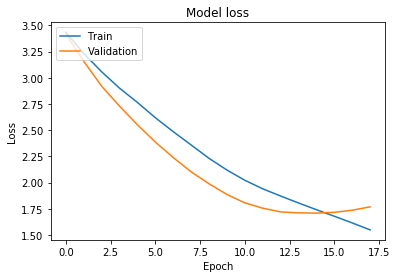

In [0]:
plot_loss(history)

### Predict for Test Set

In [0]:
predicted_2 = model_2.predict(x_test_2)

### Rescale Data

In [0]:
new_predicted_2 = []

for i in range(len(predicted_2)):
  temp = np.zeros((x_train_2.shape[2],))
  # 3 for closing price
  temp[3] = predicted_2[i]
  new_predicted_2.append(scalars_2[len(x_train_2)+i].inverse_transform(temp)[3])
  
predicted_2 = np.array(new_predicted_2)

### Plot Predictions

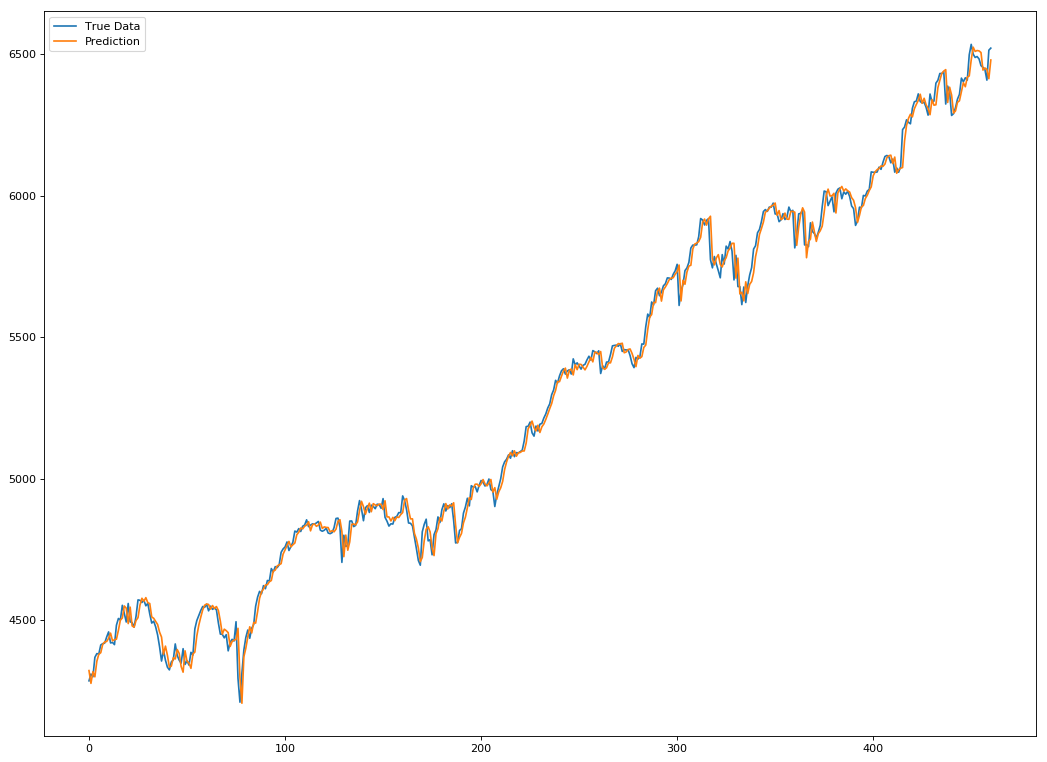

In [0]:
plot_results(predicted_2, original_data_2)

### Mean Squared Error

In [0]:
from sklearn.metrics import mean_squared_error

mean_squared_error(predicted_2, original_data_2)

1407.2343368158004

### Mean Absolute Percentage Error



In [0]:
print(np.mean(np.abs((original_data_2 - predicted_2) / original_data_2)) * 100)

0.5201249684089218


### Convert to Directional Data

In [0]:
predicted_directions_2 = directional_data(predicted_2, original_data_2)

No change: 368
Up: 57
Down: 35


In [0]:
actual_directions_2 = directional_data(original_data_2, original_data_2)

No change: 202
Up: 158
Down: 100


### Plot Confusion Matrix

In [0]:
classes = ["Down", "No Change", "Up"]
classes = np.array(classes)

indices = predicted_directions_2.argmax(axis=1)
predicted_classes_2 = classes[indices]

indices = actual_directions_2.argmax(axis=1)
y_true_2 = classes[indices]

By Count

Confusion matrix, without normalization
[[ 12  78  10]
 [ 12 171  19]
 [ 11 119  28]]


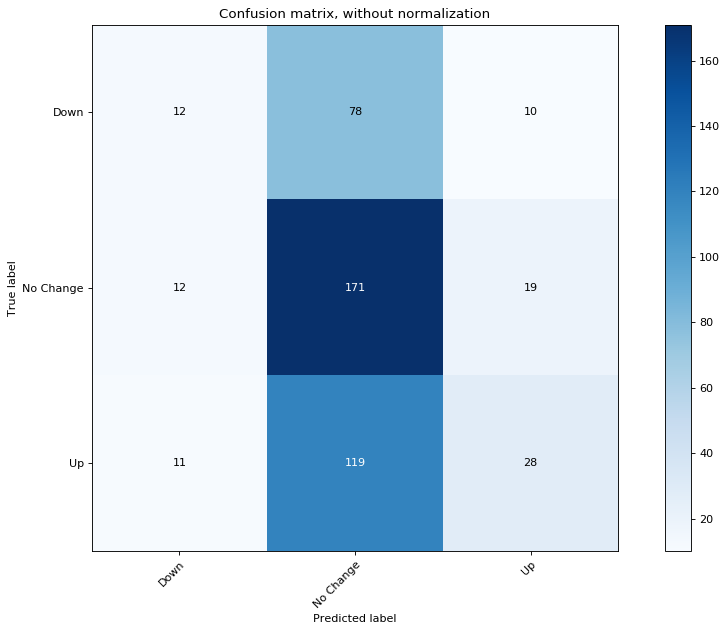

In [0]:
plot_confusion_matrix(y_true_2, predicted_classes_2, normalize=False)

Normalized

Normalized confusion matrix
[[0.12       0.78       0.1       ]
 [0.05940594 0.84653465 0.09405941]
 [0.06962025 0.75316456 0.17721519]]


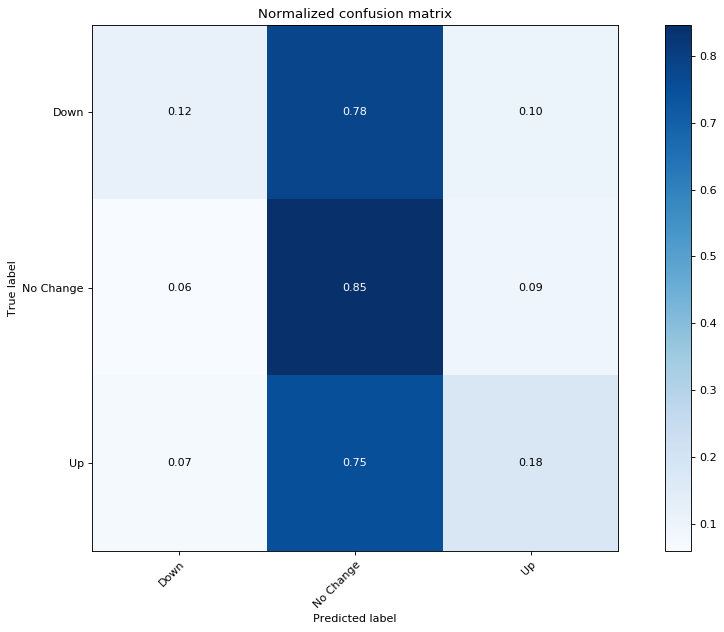

In [0]:
plot_confusion_matrix(y_true_2, predicted_classes_2, normalize=True)

### Mean Categorical Accuracy

In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true_2, predicted_classes_2)

0.45869565217391306

### Export to CSV

In [0]:
y_true_2 = np.insert(y_true_2, 0, 0)
predicted_classes_2 = np.insert(predicted_classes_2, 0, 0)

In [0]:
columns = ['Date', 'True Closing Values', 'Predicted Closing Values', 'True Values', 'Predicted Values']
data = np.array([dates_2, original_data_2, predicted_2, y_true_2, predicted_classes_2]).T

In [0]:
csv = pd.DataFrame(data, columns=columns)

csv.to_csv('csc_second_half.csv', index=False)

## Download Files

In [0]:
from google.colab import files

files.download('csc_second_half.csv')

files.download('csc_second_half.h5')

## Results

In [0]:
predicted_all = np.concatenate((predicted, predicted_2))

original_data_all = np.concatenate((original_data, original_data_2))

predicted_directions_all = np.concatenate((predicted_directions, predicted_directions_2))

actual_directions_all = np.concatenate((actual_directions, actual_directions_2))

### Mean Squared Error

In [0]:
from sklearn.metrics import mean_squared_error

mean_squared_error(predicted_all, original_data_all)

1223.727533159388

### Mean Absolute Percentage Error



In [0]:
print(np.mean(np.abs((original_data_all - predicted_all) / original_data_all)) * 100)

0.9083384765845415


### Plot Confusion Matrix

In [0]:
classes = ["Down", "No Change", "Up"]
classes = np.array(classes)

indices = predicted_directions_all.argmax(axis=1)
predicted_classes_all = classes[indices]

indices = actual_directions_all.argmax(axis=1)
y_true_all = classes[indices]

By Count

Confusion matrix, without normalization
[[ 58 159  62]
 [ 26 233  39]
 [ 35 212  96]]


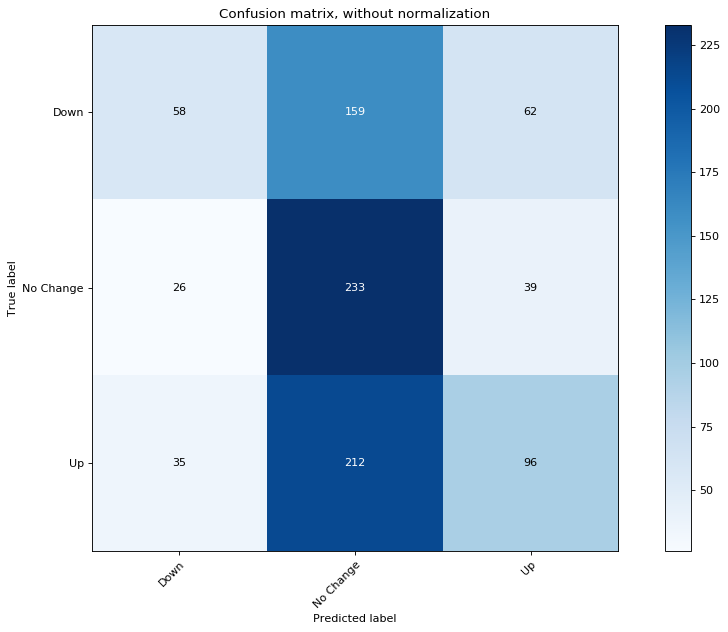

In [0]:
plot_confusion_matrix(y_true_all, predicted_classes_all, normalize=False)

Normalized

Normalized confusion matrix
[[0.2078853  0.56989247 0.22222222]
 [0.08724832 0.78187919 0.13087248]
 [0.10204082 0.6180758  0.27988338]]


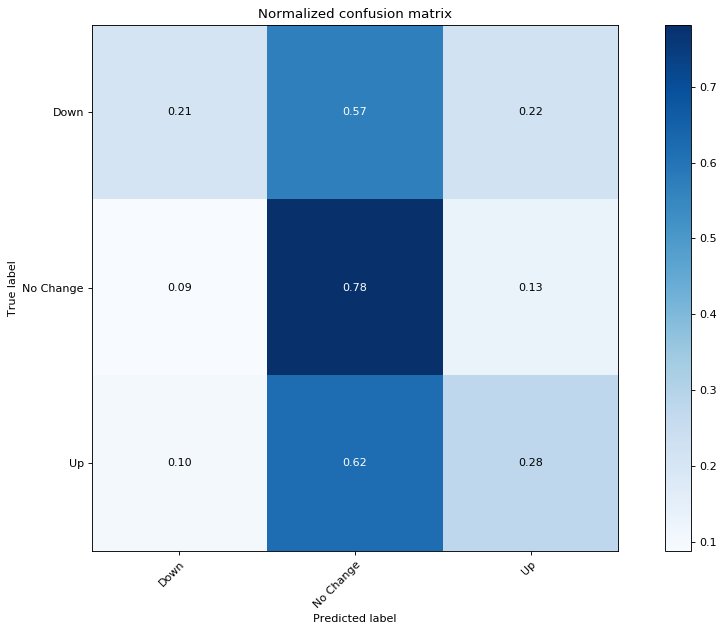

In [0]:
plot_confusion_matrix(y_true_all, predicted_classes_all, normalize=True)

### Mean Categorical Accuracy

In [0]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true_all, predicted_classes_all)

0.4206521739130435